# Product-Level Forecasting with Amazon SageMaker DeepAR

This notebook implements an end-to-end time series forecasting solution for product-level procurement data using Amazon SageMaker's DeepAR algorithm. The implementation includes:

1. **Data Loading & Exploration**: Load and analyze the procurement order data
2. **Feature Engineering**: Transform raw data into time series format with appropriate features
3. **Data Preparation for DeepAR**: Format data according to DeepAR requirements
4. **Model Training**: Train a DeepAR model with hyperparameter optimization
5. **Model Evaluation**: Evaluate model performance using test data
6. **Inference & Deployment**: Deploy model for real-time predictions
7. **Continuous Retraining**: Set up automated retraining pipeline

## Architecture Overview

```
Raw Order Data → Feature Engineering → DeepAR Training → Model Evaluation → Deployment → Continuous Retraining
```

## Why DeepAR?

DeepAR is particularly well-suited for this procurement forecasting task because:

- It can handle **multiple related time series** (different products for different customers)
- It works well with **sparse/intermittent data** (common in procurement)
- It can incorporate **categorical features** (customer, facility, product categories)
- It provides **probabilistic forecasts** (important for inventory planning)
- It can **learn patterns across similar items** (transfer learning across products)

## 1. Setup and Configuration


In [1]:
# Install required packages
!pip install -q sagemaker pandas numpy matplotlib seaborn plotly scikit-learn boto3

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import os
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
# Set up SageMaker session
sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
prefix = 'procurement-partners-hybrent-deepar'

print(f"✅ SageMaker Setup Complete!")
print(f"📍 Region: {region}")
print(f"🪣 S3 Bucket: {bucket}")
print(f"🔑 Role: {role.split('/')[-1]}")
print(f"📊 SageMaker version: {sagemaker.__version__}")

✅ SageMaker Setup Complete!
📍 Region: us-east-1
🪣 S3 Bucket: sagemaker-us-east-1-533267165065
🔑 Role: SageMaker-ExecutionRole-20250605T133175
📊 SageMaker version: 2.245.0


## 2. Data Loading and Exploration

In [4]:
# Load the order data
data_path = '/home/sagemaker-user/Hybrent.csv'
df = pd.read_csv(data_path)

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (3443987, 11)

First few rows:


,CustomerID,FacilityID,OrderID,ProductID,ProductName,CategoryName,VendorID,VendorName,CreateDate,OrderUnits,Price
0,1045,6420,9149870,288563,Cereal Toasty Os (Cheerios),Cereals,42326,US FoodsBuffalo (HPSI),07/08/2024,1.0,23.17
1,1045,6417,9148894,288563,Cereal Toasty Os (Cheerios),Cereals,42326,US FoodsBuffalo (HPSI),07/08/2024,1.0,23.17
2,1045,6417,9635115,288563,Cereal Toasty Os (Cheerios),Cereals,42326,US FoodsBuffalo (HPSI),10/21/2024,1.0,23.17
3,1045,6359,9626004,288563,Cereal Toasty Os (Cheerios),Cereals,42326,US FoodsBuffalo (HPSI),10/15/2024,1.0,23.17
4,1045,4745,9854860,288563,Cereal Toasty Os (Cheerios),Cereals,42326,US FoodsBuffalo (HPSI),12/04/2024,1.0,23.17


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

Missing values per column:
Series([], dtype: int64)


In [6]:
# Convert date columns to datetime
df['CreateDate'] = pd.to_datetime(df['CreateDate'])

# Extract basic statistics
print(f"Date range: {df['CreateDate'].min()} to {df['CreateDate'].max()}")
print(f"Number of unique customers: {df['CustomerID'].nunique()}")
print(f"Number of unique facilities: {df['FacilityID'].nunique()}")
print(f"Number of unique products: {df['ProductID'].nunique()}")
print(f"Number of unique orders: {df['OrderID'].nunique()}")

Date range: 2024-05-01 00:00:00 to 2025-06-18 00:00:00
Number of unique customers: 5
Number of unique facilities: 626
Number of unique products: 78318
Number of unique orders: 220156


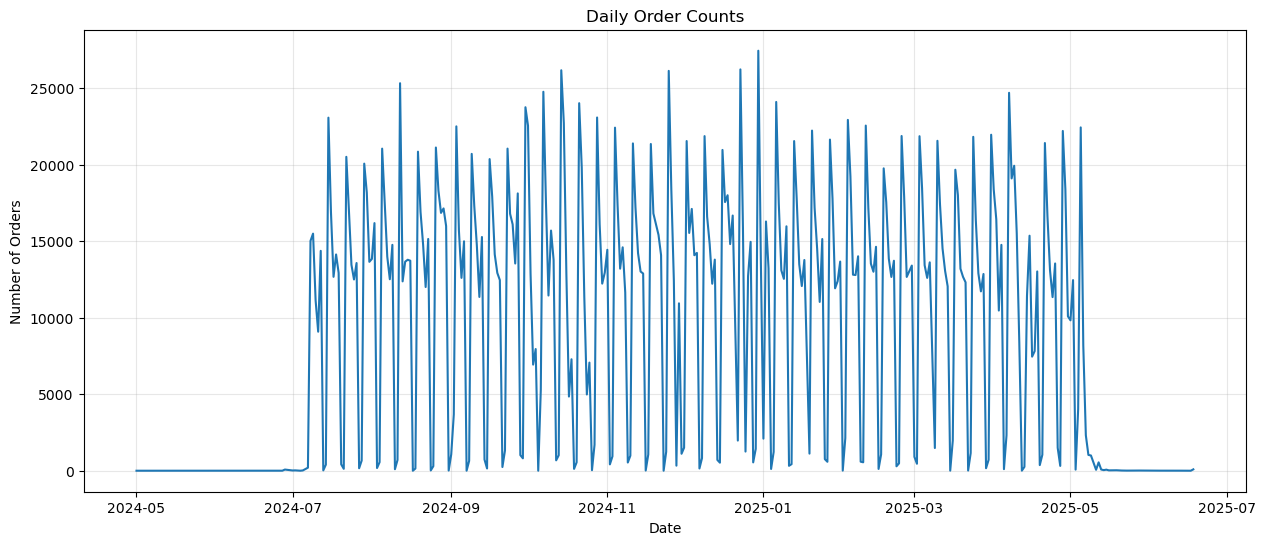

In [7]:
# Analyze order patterns over time
df['Date'] = df['CreateDate'].dt.date
daily_orders = df.groupby('Date').size().reset_index(name='OrderCount')
daily_orders['Date'] = pd.to_datetime(daily_orders['Date'])

# Plot daily order counts
plt.figure(figsize=(15, 6))
plt.plot(daily_orders['Date'], daily_orders['OrderCount'])
plt.title('Daily Order Counts')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True, alpha=0.3)
plt.show()

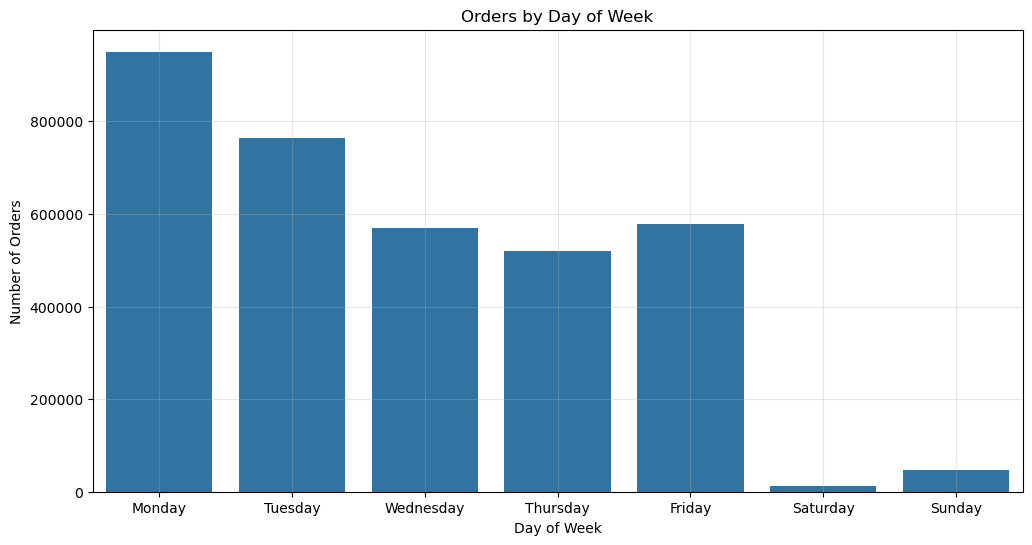

In [8]:
# Analyze weekly patterns
df['DayOfWeek'] = df['CreateDate'].dt.dayofweek
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
orders_by_day = df.groupby('DayOfWeek').size().reset_index(name='OrderCount')
orders_by_day['DayName'] = orders_by_day['DayOfWeek'].apply(lambda x: day_names[x])

plt.figure(figsize=(12, 6))
sns.barplot(x='DayName', y='OrderCount', data=orders_by_day)
plt.title('Orders by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.grid(True, alpha=0.3)
plt.show()

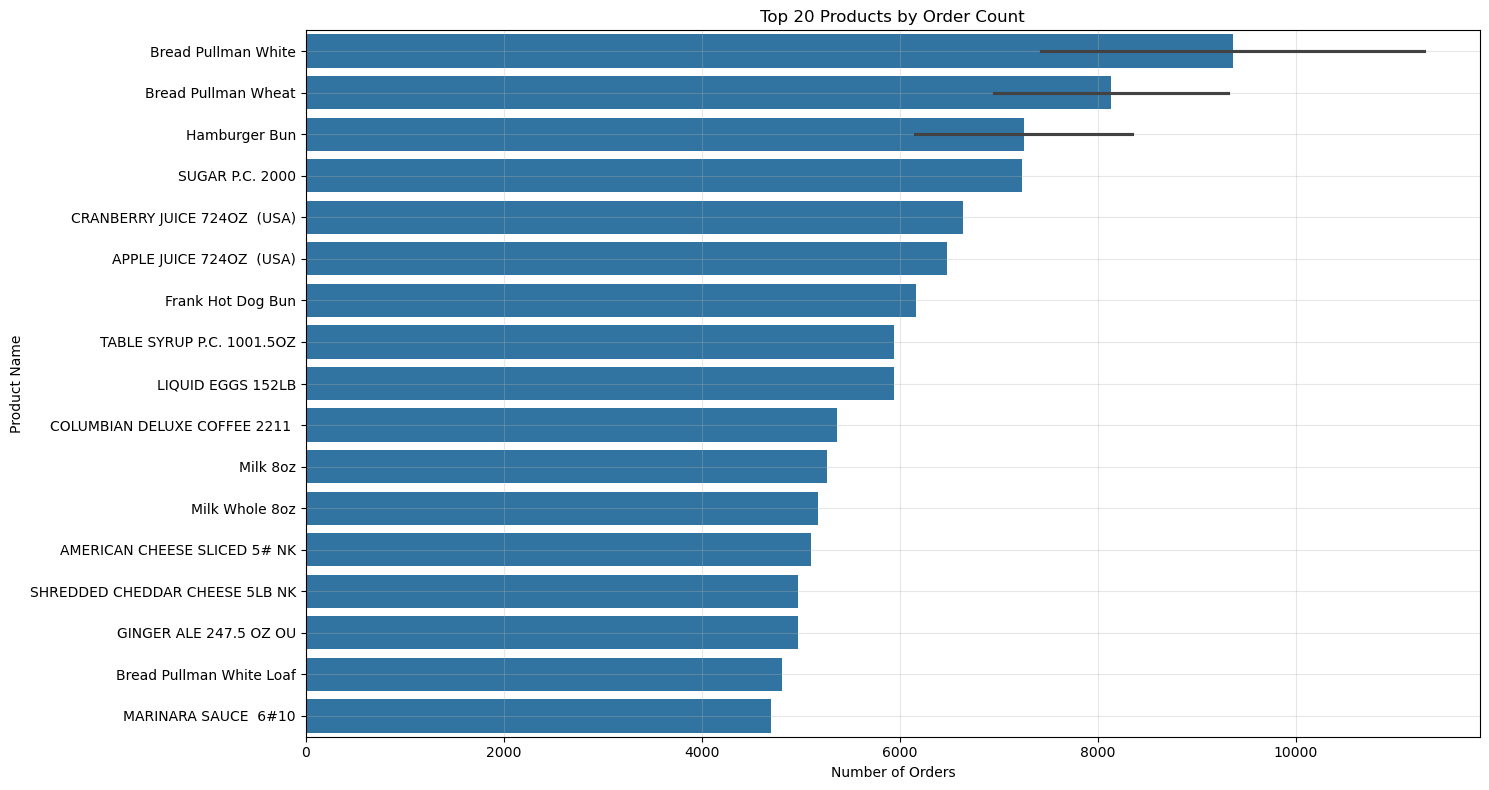

In [9]:
# Analyze top products
top_products = df.groupby(['ProductID', 'ProductName']).size().reset_index(name='OrderCount')
top_products = top_products.sort_values('OrderCount', ascending=False).head(20)

plt.figure(figsize=(15, 8))
sns.barplot(x='OrderCount', y='ProductName', data=top_products)
plt.title('Top 20 Products by Order Count')
plt.xlabel('Number of Orders')
plt.ylabel('Product Name')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Feature Engineering

In this section, we'll transform the raw order data into a format suitable for time series forecasting with DeepAR. This includes:

1. Creating a time series dataset with daily frequency
2. Extracting temporal features (day of week, month, etc.)
3. Creating categorical features for DeepAR
4. Handling missing values and sparse data

In [10]:
def extract_temporal_features(df):
    """Extract time-based features from the CreateDate"""
    print("Extracting temporal features...")
    
    # Convert date strings to datetime objects if needed
    if df['CreateDate'].dtype == 'object':
        df['CreateDate'] = pd.to_datetime(df['CreateDate'])
    
    # Basic date components
    df['OrderYear'] = df['CreateDate'].dt.year
    df['OrderMonth'] = df['CreateDate'].dt.month
    df['OrderDay'] = df['CreateDate'].dt.day
    df['OrderDayOfWeek'] = df['CreateDate'].dt.dayofweek  # Monday=0, Sunday=6
    df['OrderHour'] = df['CreateDate'].dt.hour
    
    # Cyclical encoding of time features
    df['DayOfWeek_sin'] = np.sin(df['OrderDayOfWeek'] * (2 * np.pi / 7))
    df['DayOfWeek_cos'] = np.cos(df['OrderDayOfWeek'] * (2 * np.pi / 7))
    
    df['DayOfMonth_sin'] = np.sin((df['OrderDay'] - 1) * (2 * np.pi / 31))
    df['DayOfMonth_cos'] = np.cos((df['OrderDay'] - 1) * (2 * np.pi / 31))
    
    df['MonthOfYear_sin'] = np.sin((df['OrderMonth'] - 1) * (2 * np.pi / 12))
    df['MonthOfYear_cos'] = np.cos((df['OrderMonth'] - 1) * (2 * np.pi / 12))
    
    # Quarter
    df['OrderQuarter'] = df['OrderMonth'].apply(lambda x: (x-1)//3 + 1)
    
    # Is weekend
    df['IsWeekend'] = df['OrderDayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # US holidays (simplified for 2025)
    holidays_2025 = {
        '2025-01-01': 'New Year\'s Day',
        '2025-01-20': 'Martin Luther King Jr. Day',
        '2025-02-17': 'Presidents\' Day',
        '2025-05-26': 'Memorial Day',
        '2025-06-19': 'Juneteenth',
        '2025-07-04': 'Independence Day',
        '2025-09-01': 'Labor Day',
        '2025-10-13': 'Columbus Day',
        '2025-11-11': 'Veterans Day',
        '2025-11-27': 'Thanksgiving Day',
        '2025-12-25': 'Christmas Day'
    }
    
    df['Date'] = df['CreateDate'].dt.strftime('%Y-%m-%d')
    df['IsHoliday'] = df['Date'].apply(lambda x: 1 if x in holidays_2025 else 0)
    df['HolidayName'] = df['Date'].apply(lambda x: holidays_2025.get(x, ''))
    
    return df

# Apply temporal feature extraction
df = extract_temporal_features(df)
df.head()

Extracting temporal features...


,CustomerID,FacilityID,OrderID,ProductID,ProductName,CategoryName,VendorID,VendorName,CreateDate,OrderUnits,...,DayOfWeek_sin,DayOfWeek_cos,DayOfMonth_sin,DayOfMonth_cos,MonthOfYear_sin,MonthOfYear_cos,OrderQuarter,IsWeekend,IsHoliday,HolidayName
0,1045,6420,9149870,288563,Cereal Toasty Os (Cheerios),Cereals,42326,US FoodsBuffalo (HPSI),2024-07-08,1.0,...,0.000000,1.000000,0.988468,0.151428,1.224647e-16,-1.000000e+00,3,0,0,
1,1045,6417,9148894,288563,Cereal Toasty Os (Cheerios),Cereals,42326,US FoodsBuffalo (HPSI),2024-07-08,1.0,...,0.000000,1.000000,0.988468,0.151428,1.224647e-16,-1.000000e+00,3,0,0,
2,1045,6417,9635115,288563,Cereal Toasty Os (Cheerios),Cereals,42326,US FoodsBuffalo (HPSI),2024-10-21,1.0,...,0.000000,1.000000,-0.790776,-0.612106,-1.000000e+00,-1.836970e-16,4,0,0,
3,1045,6359,9626004,288563,Cereal Toasty Os (Cheerios),Cereals,42326,US FoodsBuffalo (HPSI),2024-10-15,1.0,...,0.781831,0.623490,0.299363,-0.954139,-1.000000e+00,-1.836970e-16,4,0,0,
4,1045,4745,9854860,288563,Cereal Toasty Os (Cheerios),Cereals,42326,US FoodsBuffalo (HPSI),2024-12-04,1.0,...,0.974928,-0.222521,0.571268,0.820763,-5.000000e-01,8.660254e-01,4,0,0,


In [11]:
def prepare_product_forecast_data(df):
    """Prepare data for product-level forecasting"""
    print("Preparing product-level forecast data...")
    
    # Group by customer, facility, product, and date
    product_daily = df.groupby(['CustomerID', 'FacilityID', 'ProductID', 'Date']).size().reset_index(name='Quantity')
    
    # Add product information
    product_info = df[['ProductID', 'ProductName', 'CategoryName']].drop_duplicates()
    product_daily = product_daily.merge(product_info, on='ProductID', how='left')
    
    # Create item_id that includes ProductID for better identification
    forecast_df = pd.DataFrame({
        'item_id': (product_daily['CustomerID'].astype(str) + '_' + 
                   product_daily['FacilityID'].astype(str) + '_' + 
                   product_daily['ProductID'].astype(str)),
        'timestamp': pd.to_datetime(product_daily['Date']),
        'target_value': product_daily['Quantity'],
        'customer_id': product_daily['CustomerID'],
        'facility_id': product_daily['FacilityID'],
        'product_id': product_daily['ProductID'],
        'product_name': product_daily['ProductName'],
        'category_name': product_daily['CategoryName']
    })
    
    return forecast_df

# Prepare forecast data
forecast_df = prepare_product_forecast_data(df)
forecast_df.head()

Preparing product-level forecast data...


,item_id,timestamp,target_value,customer_id,facility_id,product_id,product_name,category_name
0,1045_1979_288175,2025-02-06,1,1045,1979,288175,Apple Macintosh 120 140ct,Produce
1,1045_1979_288175,2025-04-28,1,1045,1979,288175,Apple Macintosh 120 140ct,Produce
2,1045_1979_288176,2024-07-30,1,1045,1979,288176,Apple Red Delicious 100163ct,Produce
3,1045_1979_288176,2025-03-31,1,1045,1979,288176,Apple Red Delicious 100163ct,Produce
4,1045_1979_288176,2025-04-28,1,1045,1979,288176,Apple Red Delicious 100163ct,Produce


Number of unique time series (item_id): 452361


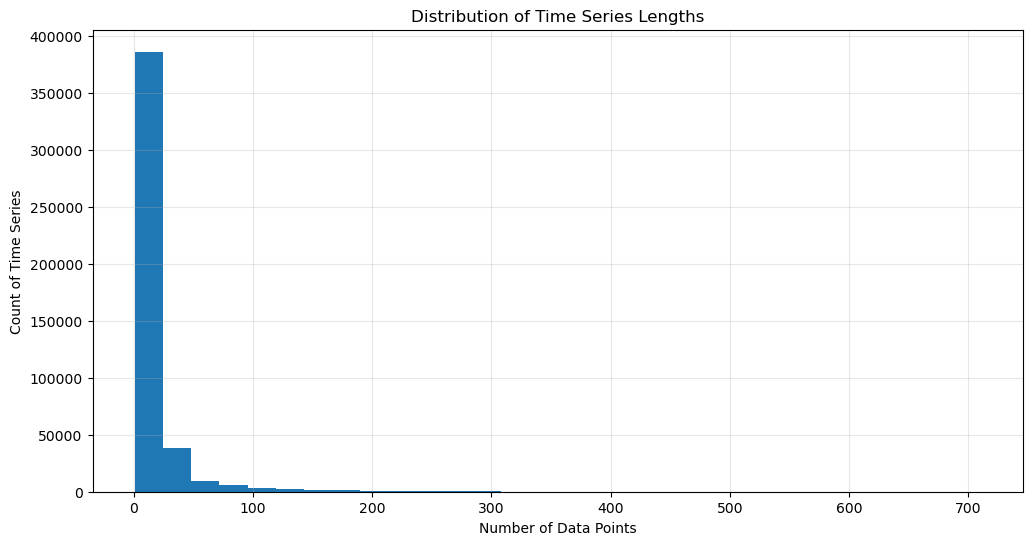

Average time series length: 14.29 data points
Median time series length: 4.00 data points
Min time series length: 1 data points
Max time series length: 710 data points


In [12]:
# Add day of week as a dynamic feature
forecast_df['day_of_week'] = forecast_df['timestamp'].dt.dayofweek

# Add month as a dynamic feature
forecast_df['month'] = forecast_df['timestamp'].dt.month

# Check the distribution of time series
print(f"Number of unique time series (item_id): {forecast_df['item_id'].nunique()}")

# Check time series length distribution
ts_lengths = forecast_df.groupby('item_id').size()
plt.figure(figsize=(12, 6))
plt.hist(ts_lengths, bins=30)
plt.title('Distribution of Time Series Lengths')
plt.xlabel('Number of Data Points')
plt.ylabel('Count of Time Series')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average time series length: {ts_lengths.mean():.2f} data points")
print(f"Median time series length: {ts_lengths.median():.2f} data points")
print(f"Min time series length: {ts_lengths.min()} data points")
print(f"Max time series length: {ts_lengths.max()} data points")

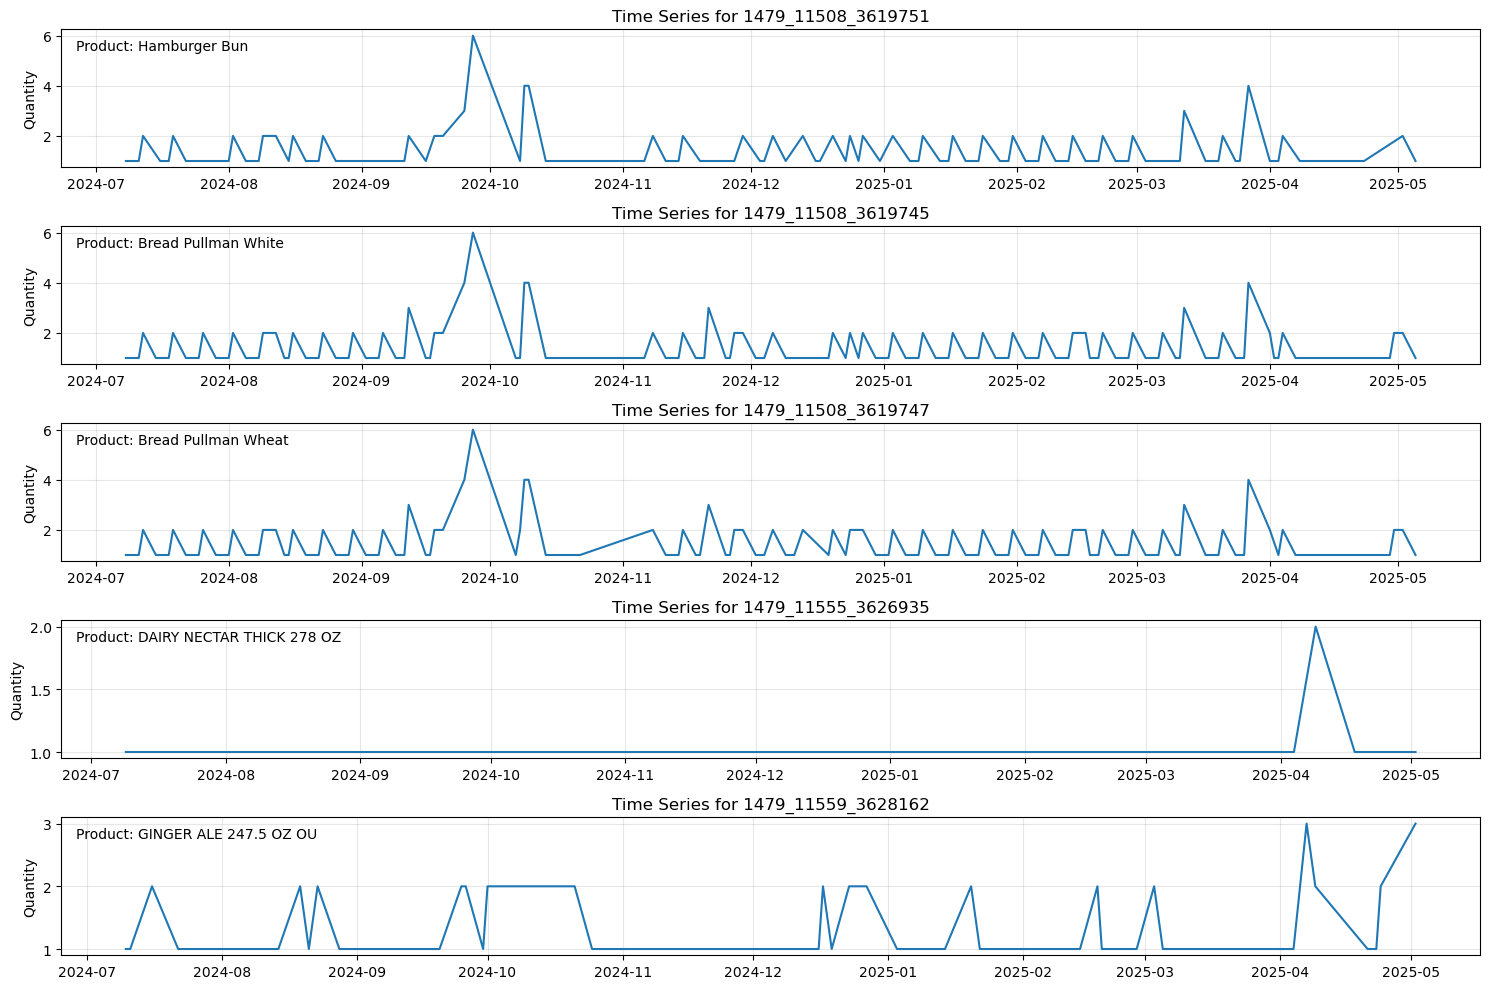

In [13]:
# Visualize a few example time series
sample_items = forecast_df['item_id'].value_counts().head(5).index.tolist()

plt.figure(figsize=(15, 10))
for i, item in enumerate(sample_items, 1):
    plt.subplot(len(sample_items), 1, i)
    item_data = forecast_df[forecast_df['item_id'] == item]
    plt.plot(item_data['timestamp'], item_data['target_value'])
    plt.title(f'Time Series for {item}')
    plt.ylabel('Quantity')
    plt.grid(True, alpha=0.3)
    
    # Add product name
    product_name = item_data['product_name'].iloc[0]
    plt.text(0.01, 0.85, f"Product: {product_name}", transform=plt.gca().transAxes)
    
plt.tight_layout()
plt.show()

## 4. Data Preparation for DeepAR

DeepAR requires data in a specific JSON Lines format. Each time series is represented as a JSON object with:
- `start`: The timestamp of the first value
- `target`: The array of target values
- `cat` (optional): Categorical features as an array of integers
- `dynamic_feat` (optional): Time-dependent features as arrays

In [14]:
def prepare_deepar_data(forecast_df, prediction_length=14, context_length=28):
    """Prepare data in DeepAR format with remapped categorical features and product information"""
    print("Preparing data for DeepAR with product information...")
    
    # Sort data by item_id and timestamp
    forecast_df = forecast_df.sort_values(['item_id', 'timestamp'])
    
    # Group by item_id
    grouped = forecast_df.groupby('item_id')
    
    # Filter time series with enough data points
    min_ts_length = context_length + prediction_length
    valid_groups = [name for name, group in grouped if len(group) >= min_ts_length]
    print(f"Filtered from {grouped.ngroups} to {len(valid_groups)} time series with at least {min_ts_length} data points")
    
    # Collect the actual customer, facility, and category values used in valid time series
    used_customers = set()
    used_facilities = set()
    used_categories = set()
    
    for item_id in valid_groups:
        group = grouped.get_group(item_id)
        used_customers.add(group['customer_id'].iloc[0])
        used_facilities.add(group['facility_id'].iloc[0])
        used_categories.add(group['category_name'].iloc[0])
    
    # Create new mappings with consecutive integers (no gaps)
    used_customer_list = sorted(list(used_customers))
    used_facility_list = sorted(list(used_facilities))
    used_category_list = sorted(list(used_categories))
    
    customer_mapping = {cust: i for i, cust in enumerate(used_customer_list)}
    facility_mapping = {fac: i for i, fac in enumerate(used_facility_list)}
    category_mapping = {cat: i for i, cat in enumerate(used_category_list)}
    
    print(f"Remapped {len(used_customers)} customers to consecutive values 0-{len(used_customers)-1}")
    print(f"Remapped {len(used_facilities)} facilities to consecutive values 0-{len(used_facilities)-1}")
    print(f"Remapped {len(used_categories)} categories to consecutive values 0-{len(used_categories)-1}")
    
    # Create a reverse mapping to store with the model
    reverse_customer_mapping = {i: cust for cust, i in customer_mapping.items()}
    reverse_facility_mapping = {i: fac for fac, i in facility_mapping.items()}
    reverse_category_mapping = {i: cat for cat, i in category_mapping.items()}
    
    # Prepare training and test data
    train_data = []
    test_data = []
    
    # Create a mapping from item_id to product information
    item_to_product_info = {}
    for item_id in valid_groups:
        group = grouped.get_group(item_id)
        first_row = group.iloc[0]
        
        # Extract product information
        product_id = first_row.get('product_id', None)
        product_name = first_row.get('product_name', f"Product {product_id}")
        category_name = first_row.get('category_name', 'Unknown')
        customer_id = first_row.get('customer_id', None)
        facility_id = first_row.get('facility_id', None)
        
        # Store product information
        item_to_product_info[item_id] = {
            'product_id': product_id,
            'product_name': product_name,
            'category_name': category_name,
            'customer_id': customer_id,
            'facility_id': facility_id
        }
    
    # Process each valid item
    for item_id in valid_groups:
        group = grouped.get_group(item_id)
        
        # Get categorical features
        customer_id = group['customer_id'].iloc[0]
        facility_id = group['facility_id'].iloc[0]
        category_name = group['category_name'].iloc[0]
        
        # Map categorical features to integers using our remapped values
        cat_features = [
            customer_mapping[customer_id],
            facility_mapping[facility_id],
            category_mapping[category_name]
        ]
        
        # Get dynamic features (day of week and month)
        day_of_week = group['day_of_week'].tolist()
        month = group['month'].tolist()
        
        # Normalize dynamic features
        day_of_week_norm = [d/6 for d in day_of_week]  # Normalize to [0,1]
        month_norm = [(m-1)/11 for m in month]  # Normalize to [0,1]
        
        # Get target values
        target = group['target_value'].tolist()
        
        # Get start timestamp
        start = group['timestamp'].min().strftime('%Y-%m-%d')
        
        # Get product information
        product_info = item_to_product_info.get(item_id, {})
        
        # Create training instance (use all data)
        train_instance = {
            "start": start,
            "target": target,
            "cat": cat_features,
            "dynamic_feat": [day_of_week_norm, month_norm],
            "item_id": item_id,
            "product_info": {
                "product_id": product_id,
                "product_name": group['product_name'].iloc[0] if 'product_name' in group.columns else f"Product {product_id}",
                "category_name": category_name,
                "customer_id": customer_id,
                "facility_id": facility_id
            }
        }
        train_data.append(train_instance)
        
        # Create test instance (withhold last prediction_length points)
        test_target = target[:-prediction_length]
        test_day_of_week = day_of_week_norm[:-prediction_length]
        test_month = month_norm[:-prediction_length]
        
        # Create test instance (withhold last prediction_length points)
        test_instance = {
            "start": start,
            "target": test_target,
            "cat": cat_features,
            "dynamic_feat": [test_day_of_week, test_month],
            "item_id": item_id,
            "product_info": {
                "product_id": product_id,
                "product_name": group['product_name'].iloc[0] if 'product_name' in group.columns else f"Product {product_id}",
                "category_name": category_name,
                "customer_id": customer_id,
                "facility_id": facility_id
            }
        }
        test_data.append(test_instance)
    
    # Calculate actual cardinality based on remapped values
    cardinality = [len(used_customer_list), len(used_facility_list), len(used_category_list)]
    print(f"Categorical feature cardinality: {cardinality}")
    
    return train_data, test_data, {
        'customer_mapping': customer_mapping,
        'facility_mapping': facility_mapping,
        'category_mapping': category_mapping,
        'reverse_customer_mapping': reverse_customer_mapping,
        'reverse_facility_mapping': reverse_facility_mapping,
        'reverse_category_mapping': reverse_category_mapping,
        'cardinality': cardinality,
        'used_customer_list': used_customer_list,
        'used_facility_list': used_facility_list,
        'used_category_list': used_category_list,
        'item_to_product_info': item_to_product_info  # Include product information mapping
    }

In [15]:
# Set prediction and context lengths
prediction_length = 14  # Forecast horizon (14 days)
context_length = 28     # Context window (28 days)

# Prepare data for DeepAR
train_data, test_data, feature_mappings = prepare_deepar_data(
    forecast_df, 
    prediction_length=prediction_length, 
    context_length=context_length
)

# Print categorical feature information
print("\nRemapped categorical features:")
print(f"Customers: {len(feature_mappings['used_customer_list'])} unique values")
print(f"Facilities: {len(feature_mappings['used_facility_list'])} unique values")
print(f"Product categories: {len(feature_mappings['used_category_list'])} unique values")
print(f"\nCardinality: {feature_mappings['cardinality']}")

Preparing data for DeepAR with product information...
Filtered from 452361 to 34950 time series with at least 42 data points
Remapped 5 customers to consecutive values 0-4
Remapped 536 facilities to consecutive values 0-535
Remapped 166 categories to consecutive values 0-165
Categorical feature cardinality: [5, 536, 166]

Remapped categorical features:
Customers: 5 unique values
Facilities: 536 unique values
Product categories: 166 unique values

Cardinality: [5, 536, 166]


In [16]:
# Save feature mappings for later use
import pickle

with open('feature_mappings.pkl', 'wb') as f:
    pickle.dump(feature_mappings, f)

# Upload to S3
feature_mappings_s3_key = f"{prefix}/feature_mappings/feature_mappings.pkl"
boto3.Session().resource('s3').Bucket(bucket).upload_file(
    'feature_mappings.pkl', 
    feature_mappings_s3_key
)

print(f"Feature mappings saved to s3://{bucket}/{feature_mappings_s3_key}")

Feature mappings saved to s3://sagemaker-us-east-1-533267165065/procurement-partners-hybrent-deepar/feature_mappings/feature_mappings.pkl


In [17]:
# Write data to JSON Lines files
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            # Create a copy for DeepAR (without product_info)
            deepar_instance = {
                "start": d["start"],
                "target": d["target"],
                "cat": d["cat"] if "cat" in d else None,
                "dynamic_feat": d["dynamic_feat"] if "dynamic_feat" in d else None,
                "item_id": d["item_id"] if "item_id" in d else None
            }
            # Remove None values
            deepar_instance = {k: v for k, v in deepar_instance.items() if v is not None}
            fp.write(json.dumps(deepar_instance).encode('utf-8'))
            fp.write('\n'.encode('utf-8'))

# Function to save product information mapping separately
def save_product_info_mapping(feature_mappings, path='product_info_mapping.json'):
    """Save product information mapping to a JSON file"""
    # Extract product information mapping
    item_to_product_info = feature_mappings.get('item_to_product_info', {})
    
    # Convert to JSON-serializable format
    for item_id, product_info in item_to_product_info.items():
        for key, value in product_info.items():
            if not isinstance(value, (int, float, str, bool, type(None))):
                product_info[key] = str(value)
    
    # Save to file
    with open(path, 'w') as f:
        json.dump(item_to_product_info, f, indent=2)
    
    print(f"Saved product information mapping to {path}")

# Write training and test data to files
write_dicts_to_file('train.json', train_data)
write_dicts_to_file('test.json', test_data)

# Save product information mapping separately
save_product_info_mapping(feature_mappings)

# Upload to S3
s3_train_path = f"{prefix}/data/train/train.json"
s3_test_path = f"{prefix}/data/test/test.json"

boto3.Session().resource('s3').Bucket(bucket).upload_file(
    'train.json', 
    s3_train_path
)

boto3.Session().resource('s3').Bucket(bucket).upload_file(
    'test.json', 
    s3_test_path
)

print(f"Training data uploaded to s3://{bucket}/{s3_train_path}")
print(f"Test data uploaded to s3://{bucket}/{s3_test_path}")

Saved product information mapping to product_info_mapping.json
Training data uploaded to s3://sagemaker-us-east-1-533267165065/procurement-partners-hybrent-deepar/data/train/train.json
Test data uploaded to s3://sagemaker-us-east-1-533267165065/procurement-partners-hybrent-deepar/data/test/test.json


## 5. Train DeepAR Model

Now we'll train a DeepAR model using the prepared data. We'll configure the model with appropriate hyperparameters and use the SageMaker Python SDK to launch a training job.

In [18]:
# Get the DeepAR container
from sagemaker.image_uris import retrieve

container = retrieve("forecasting-deepar", region)
print(f"Using DeepAR container: {container}")

Using DeepAR container: 522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1


In [19]:
# Set up hyperparameters with explicit cardinality
hyperparameters = {
    "time_freq": "D",              # Daily frequency
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",             # Number of cells in each hidden layer
    "num_layers": "3",             # Number of hidden layers
    "dropout_rate": "0.05",        # Dropout regularization
    "embedding_dimension": "10",   # Size of embedding vector for categorical features
    "mini_batch_size": "64",       # Mini batch size for training
    "learning_rate": "0.001",      # Learning rate
    "epochs": "400",               # Number of epochs
    "early_stopping_patience": "40", # Early stopping patience
    "num_dynamic_feat": "2",       # Number of dynamic features (day of week, month)
    "cardinality": str(feature_mappings['cardinality']).replace(" ", "")  # Explicit cardinality based on remapped values
}

print(f"Using hyperparameters:\n{json.dumps(hyperparameters, indent=2)}")

Using hyperparameters:
{
  "time_freq": "D",
  "context_length": "28",
  "prediction_length": "14",
  "num_cells": "40",
  "num_layers": "3",
  "dropout_rate": "0.05",
  "embedding_dimension": "10",
  "mini_batch_size": "64",
  "learning_rate": "0.001",
  "epochs": "400",
  "early_stopping_patience": "40",
  "num_dynamic_feat": "2",
  "cardinality": "[5,536,166]"
}


In [28]:
# Set up the estimator
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c5.2xlarge",  # You can adjust based on your dataset size
    output_path=f"s3://{bucket}/{prefix}/output",
    sagemaker_session=sagemaker_session,
    base_job_name="hybrent-deepar"
)

# Set hyperparameters
estimator.set_hyperparameters(**hyperparameters)

In [29]:
# Define data channels
data_channels = {
    "train": f"s3://{bucket}/{s3_train_path}",
    "test": f"s3://{bucket}/{s3_test_path}"
}

# Train the model
print("Starting DeepAR training job...")
estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: hybrent-deepar-2025-07-10-17-16-57-483


Starting DeepAR training job...
2025-07-10 17:16:58 Starting - Starting the training job...
2025-07-10 17:17:33 Downloading - Downloading input data...
2025-07-10 17:17:48 Downloading - Downloading the training image.........
2025-07-10 17:19:14 Training - Training image download completed. Training in progress..

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6                                                                                             │
│    7 # Train the model                                                                           │
│    8 print("Starting DeepAR training job...")                                                    │
│ ❱  9 estimator.fit(inputs=data_channels)                                                         │
│   10                                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py:167 in wrapper  │
│                                                                                                  │
│   164 │   │   │   │   │   caught_ex = e                                                          │
│   165 │   │   │   │   finally:                                                                   │
│   166 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 167 │   │   │   │   │   │   raise caught_ex                                                    │
│   168 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   169 │   │   │   else:                                                                          │
│   170 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py:138 in wrapper  │
│                                                                                                  │
│   135 │   │   │   │   start_timer = perf_counter()                                               │
│   136 │   │   │   │   try:                                                                       │
│   137 │   │   │   │   │   # Call the original function                                           │
│ ❱ 138 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   139 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   140 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   141 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/workflow/pipeline_context.py:346 in wrapper    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/estimator

## 6. Model Evaluation

After training, we'll evaluate the model's performance on the test dataset. DeepAR provides various metrics like RMSE, MAPE, and weighted quantile loss.

In [30]:
# Get the training job name
job_name = estimator.latest_training_job.job_name
print(f"Training job name: {job_name}")

# Get the training job description
client = boto3.client('sagemaker')
response = client.describe_training_job(TrainingJobName=job_name)

# Extract metrics
metrics = response['FinalMetricDataList']
for metric in metrics:
    print(f"{metric['MetricName']}: {metric['Value']:.4f}")

Training job name: hybrent-deepar-2025-07-10-17-16-57-483
test:mean_wQuantileLoss: 0.0265
train:progress: 100.0000
train:loss:batch: -4.0724
train:throughput: 503.4697
test:RMSE: 0.1839
train:final_loss: -4.7059
train:loss: -4.5695


### Understanding DeepAR Metrics

- **RMSE (Root Mean Square Error)**: Measures the square root of the average squared difference between predicted and actual values. Lower is better.
- **MASE (Mean Absolute Scaled Error)**: Compares the model's performance to a naive forecast. Values < 1 indicate the model is better than a naive approach.
- **MAPE (Mean Absolute Percentage Error)**: Average percentage difference between predicted and actual values.
- **wQL (Weighted Quantile Loss)**: Measures the accuracy of predicted quantiles. Lower is better.
- **WAPE (Weighted Absolute Percentage Error)**: Similar to MAPE but weighted by the magnitude of actual values.

## 7. Model Deployment and Inference

Now we'll deploy the trained model to a SageMaker endpoint for real-time inference.

In [31]:
# Create a custom predictor class for DeepAR
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, endpoint_name, sagemaker_session=None):
        super(DeepARPredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=JSONSerializer(),
            deserializer=JSONDeserializer()
        )
    
    def predict(self, data, quantiles=["0.1", "0.5", "0.9"], num_samples=100):
        """Generate forecasts from input data
        
        Args:
            data (dict): Input data in DeepAR format
            quantiles (list): Quantiles to predict
            num_samples (int): Number of samples to generate
            
        Returns:
            dict: Predictions including quantiles and samples
        """
        # Create request configuration
        req = {
            "instances": [data],
            "configuration": {
                "num_samples": num_samples,
                "output_types": ["quantiles", "samples"],
                "quantiles": quantiles
            }
        }
        
        # Call the endpoint
        response = super(DeepARPredictor, self).predict(req)
        return response

In [32]:
# Deploy the model to an endpoint
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    predictor_cls=DeepARPredictor
)

print(f"Model deployed to endpoint: {predictor.endpoint_name}")

INFO:sagemaker:Creating model with name: hybrent-deepar-2025-07-20-23-56-22-287
INFO:sagemaker:Creating endpoint-config with name hybrent-deepar-2025-07-20-23-56-22-287
INFO:sagemaker:Creating endpoint with name hybrent-deepar-2025-07-20-23-56-22-287


---------!Model deployed to endpoint: hybrent-deepar-2025-07-20-23-56-22-287


In [49]:

# Function to create a test instance for prediction
def create_test_instance(item_id, forecast_df, feature_mappings, context_length, prediction_length=14):
    """Create a test instance for a specific item_id with remapped categorical features
    and dynamic features for both context and prediction periods"""
    # Get data for the item
    item_data = forecast_df[forecast_df['item_id'] == item_id].sort_values('timestamp')
    
    if len(item_data) < context_length:
        print(f"Warning: Item {item_id} has only {len(item_data)} data points, less than context_length {context_length}")
        return None
    
    # Get the most recent context_length data points
    recent_data = item_data.tail(context_length)
    
    # Get categorical features
    customer_id = recent_data['customer_id'].iloc[0]
    facility_id = recent_data['facility_id'].iloc[0]
    category_name = recent_data['category_name'].iloc[0]
    
    # Verify categorical features exist in mappings
    if customer_id not in feature_mappings['customer_mapping']:
        print(f"Warning: Customer ID {customer_id} not found in mapping. Using default value 0.")
        customer_cat = 0
    else:
        customer_cat = feature_mappings['customer_mapping'][customer_id]
        
    if facility_id not in feature_mappings['facility_mapping']:
        print(f"Warning: Facility ID {facility_id} not found in mapping. Using default value 0.")
        facility_cat = 0
    else:
        facility_cat = feature_mappings['facility_mapping'][facility_id]
        
    if category_name not in feature_mappings['category_mapping']:
        print(f"Warning: Category {category_name} not found in mapping. Using default value 0.")
        category_cat = 0
    else:
        category_cat = feature_mappings['category_mapping'][category_name]
    
    # Map categorical features to integers using our remapped values
    cat_features = [
        customer_cat,
        facility_cat,
        category_cat
    ]
    
    # Get dynamic features for the context period
    day_of_week = recent_data['day_of_week'].tolist()
    month = recent_data['month'].tolist()
    
    # Generate dynamic features for the prediction period
    last_date = recent_data['timestamp'].iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_length, freq='D')
    future_day_of_week = [d.dayofweek for d in future_dates]
    future_month = [d.month for d in future_dates]
    
    # Combine context and prediction period features
    full_day_of_week = day_of_week + future_day_of_week
    full_month = month + future_month
    
    # Normalize dynamic features
    day_of_week_norm = [d/6 for d in full_day_of_week]  # Normalize to [0,1]
    month_norm = [(m-1)/11 for m in full_month]  # Normalize to [0,1]
    
    # Get target values
    target = recent_data['target_value'].tolist()
    
    # Get start timestamp
    start = recent_data['timestamp'].min().strftime('%Y-%m-%d')
    
    # Create test instance
    test_instance = {
        "start": start,
        "target": target,
        "cat": cat_features,
        "dynamic_feat": [day_of_week_norm, month_norm]
    }
    
    return test_instance

In [53]:

from sagemaker.predictor import Predictor
# Load feature mappings
with open('feature_mappings.pkl', 'rb') as f:
    feature_mappings = pickle.load(f)

# Select a sample item for prediction
sample_item_id = forecast_df['item_id'].value_counts().head(1).index[0]
print(f"Generating forecast for item: {sample_item_id}")

# Get product name
product_name = forecast_df[forecast_df['item_id'] == sample_item_id]['product_name'].iloc[0]
print(f"Product: {product_name}")

# Create test instance with dynamic features for both context and prediction periods
test_instance = create_test_instance(sample_item_id, forecast_df, feature_mappings, context_length, prediction_length)

# Replace with your actual endpoint name
endpoint_name = "hybrent-deepar-2025-07-20-23-56-22-287"

# Create the Predictor object
predictor = Predictor(endpoint_name=endpoint_name,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

# Generate forecast
payload = {
    "instances": [test_instance],
    "configuration": {
        "output_types": ["mean", "quantiles", "samples"],
        "quantiles": ["0.1", "0.5", "0.9"]
    }
}

forecast = predictor.predict(payload)

# Extract predictions
predictions = forecast['predictions'][0]
quantiles = predictions['quantiles']
samples = predictions['samples']

# Print quantile predictions
print("\nQuantile Predictions:")
for q, values in quantiles.items():
    print(f"Quantile {q}: {values[:5]}...")

Generating forecast for item: 1479_11508_3619751
Product: Hamburger Bun

Quantile Predictions:
Quantile 0.1: [0.9968829751, 0.9976327419, 0.9977430105, 0.9926074743, 0.996214211]...
Quantile 0.5: [0.9990350604, 0.9997239709, 0.9999771714, 0.9957159162, 0.9981231093]...
Quantile 0.9: [1.0015040636, 1.001658082, 1.0023185015, 0.998000145, 1.0001815557]...


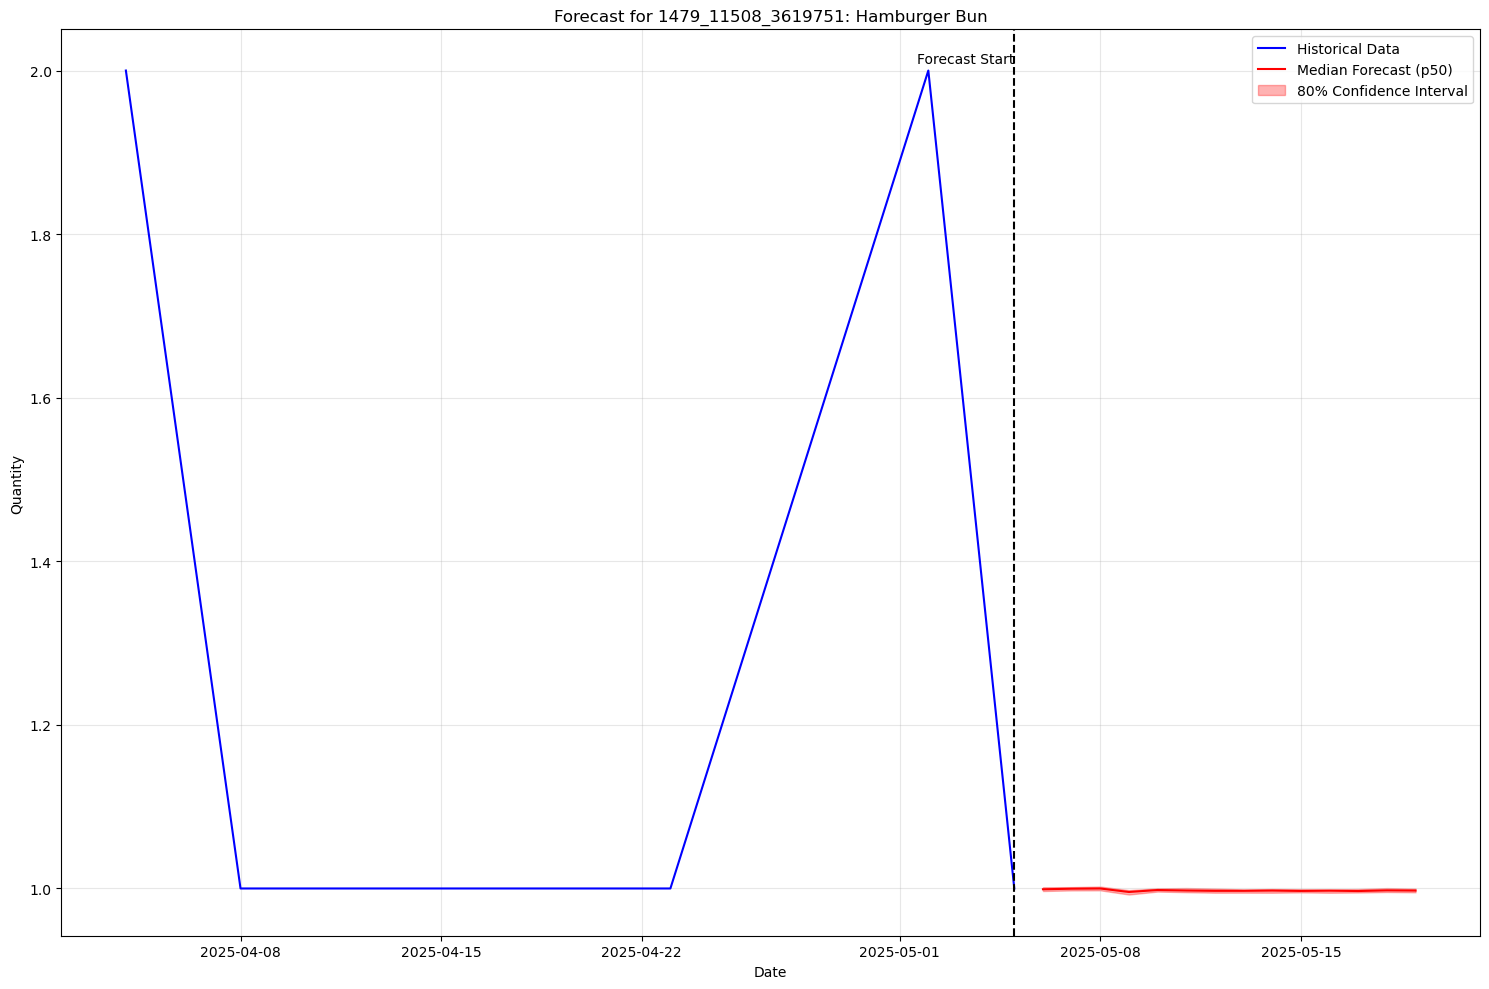

In [54]:
# Visualize the forecast
def plot_forecast(item_id, forecast_df, predictions, context_length, prediction_length):
    """Plot historical data and forecast"""
    # Get data for the item
    item_data = forecast_df[forecast_df['item_id'] == item_id].sort_values('timestamp')
    
    # Get the most recent data points
    historical_data = item_data.tail(context_length)
    
    # Create forecast dates
    last_date = historical_data['timestamp'].max()
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_length, freq='D')
    
    # Extract quantiles
    quantiles = predictions['quantiles']
    p10 = quantiles['0.1']
    p50 = quantiles['0.5']
    p90 = quantiles['0.9']
    
    # Plot
    plt.figure(figsize=(15, 10))
    
    # Plot historical data
    plt.plot(historical_data['timestamp'], historical_data['target_value'], label='Historical Data', color='blue')
    
    # Plot forecast
    plt.plot(forecast_dates, p50, label='Median Forecast (p50)', color='red')
    plt.fill_between(forecast_dates, p10, p90, color='red', alpha=0.3, label='80% Confidence Interval')
    
    # Add labels and title
    plt.title(f'Forecast for {item_id}: {item_data["product_name"].iloc[0]}')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add vertical line to separate historical data and forecast
    plt.axvline(x=last_date, color='black', linestyle='--')
    plt.text(last_date, plt.ylim()[1]*0.98, 'Forecast Start', ha='right')
    
    plt.tight_layout()
    plt.show()

# Plot the forecast
plot_forecast(sample_item_id, forecast_df, predictions, context_length, prediction_length)

## Testing

In [55]:
# Connect to the deployed endpoint
#endpoint_name = "procurement-deepar-2025-07-09-13-42-14-728"
print(f"Using endpoint: {endpoint_name}")

# Create a simple predictor class to interact with the endpoint directly
class DirectDeepARPredictor:
    def __init__(self, endpoint_name):
        self.endpoint_name = endpoint_name
        self.runtime = boto3.client('sagemaker-runtime')
    
    def predict(self, data, quantiles=["0.1", "0.5", "0.9"], num_samples=100):
        # Create request configuration
        req = {
            "instances": [data],
            "configuration": {
                "num_samples": num_samples,
                "output_types": ["quantiles", "samples"],
                "quantiles": quantiles
            }
        }
        
        # Convert to JSON
        req_json = json.dumps(req)
        
        # Call the endpoint
        response = self.runtime.invoke_endpoint(
            EndpointName=self.endpoint_name,
            ContentType='application/json',
            Body=req_json
        )
        
        # Parse the response
        result = json.loads(response['Body'].read().decode())
        return result

# Create predictor instance for direct endpoint access
direct_predictor = DirectDeepARPredictor(endpoint_name)

# Load product information mapping
def load_product_info_mapping(path='product_info_mapping.json'):
    """Load product information mapping from a JSON file"""
    try:
        with open(path, 'r') as f:
            item_to_product_info = json.load(f)
        print(f"Loaded product information for {len(item_to_product_info)} items")
        return item_to_product_info
    except Exception as e:
        print(f"Warning: Could not load product information mapping: {str(e)}")
        return {}

# Load the product information mapping
product_info_mapping = load_product_info_mapping()

Using endpoint: hybrent-deepar-2025-07-20-23-56-22-287
Loaded product information for 34950 items


Using endpoint: hybrent-deepar-2025-07-20-23-56-22-287
Loading test data from test.json...
Loaded 34950 test instances
Testing with instance: 2024-07-15, target length: 29
Product: Bottle Deposit 1
Predictions (p50): [0.99914443 0.9992038  0.99940556 0.99937338 0.99946117]...


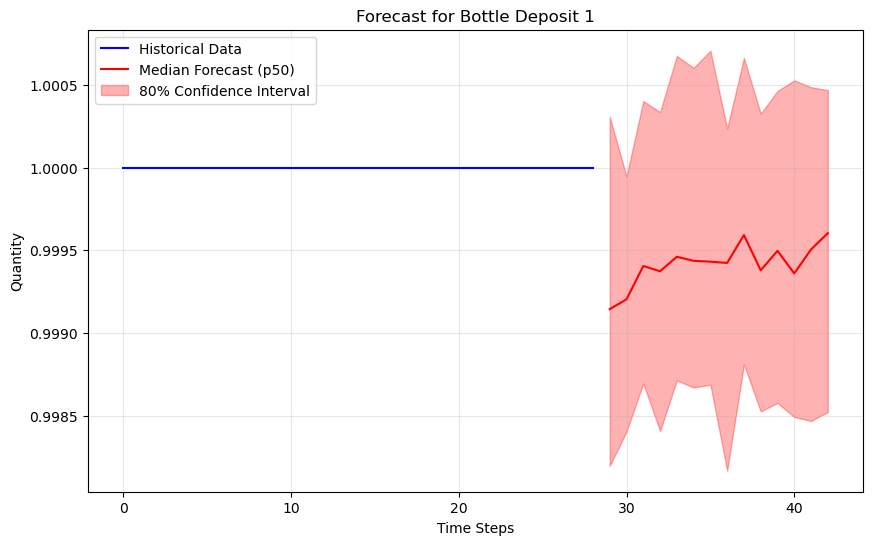

✅ Test successful! The endpoint is working correctly.


In [60]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boto3
from datetime import datetime, timedelta

# Define the prediction length
prediction_length = 14
print(f"Using endpoint: {endpoint_name}")
# Function to test the endpoint with a single instance
def test_endpoint_with_instance(test_instance, endpoint_name=f"{endpoint_name}"):
    """Test the DeepAR endpoint with a single instance from test.json"""
    # Extract information from the test instance
    start_date = test_instance['start']
    target = test_instance['target']
    cat = test_instance['cat'] if 'cat' in test_instance else None
    item_id = test_instance.get('item_id', None)
    product_info = test_instance.get('product_info', {})
    
    # Parse the start date
    start_date_dt = pd.Timestamp(start_date)
    
    # Calculate the last date in the context window
    last_date = start_date_dt + pd.Timedelta(days=len(target)-1)
    
    # Generate future dates for the prediction period
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_length, freq='D')
    
    # Create dynamic features for the entire period (historical + prediction)
    if 'dynamic_feat' in test_instance:
        dynamic_feat = test_instance['dynamic_feat']
        extended_dynamic_feat = []
        
        for feat_idx, feat in enumerate(dynamic_feat):
            # Convert all values to float
            numeric_feat = [float(x) for x in feat]
            
            # Generate future values based on the feature index
            if feat_idx == 0:  # Day of week feature
                future_values = [float(d.dayofweek)/6 for d in future_dates]
            elif feat_idx == 1:  # Month feature
                future_values = [float(d.month-1)/11 for d in future_dates]
            else:
                # For other features, repeat the last value
                future_values = [float(numeric_feat[-1])] * prediction_length
            
            # Combine historical and future values
            extended_feat = numeric_feat + future_values
            extended_dynamic_feat.append(extended_feat)
    else:
        extended_dynamic_feat = None
    
    # Create the request payload - NOTE: Do not include NaN values in target
    request_instance = {
        "start": start_date,
        "target": [float(x) for x in target],  # Only include historical values
        "cat": cat
    }
    
    if extended_dynamic_feat:
        request_instance["dynamic_feat"] = extended_dynamic_feat
    
    request_payload = {
        "instances": [request_instance],
        "configuration": {
            "num_samples": 100,
            "output_types": ["quantiles"],
            "quantiles": ["0.1", "0.5", "0.9"]
        }
    }
    
    # Generate forecast
    try:
        # Use boto3 directly
        runtime = boto3.client('sagemaker-runtime')
        
        response = runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType='application/json',
            Body=json.dumps(request_payload)
        )
        
        # Parse the response
        result = json.loads(response['Body'].read().decode())
        predictions = result['predictions'][0]
        
        # Add item_id and product_info to predictions
        if item_id:
            predictions['item_id'] = item_id
        if product_info:
            predictions['product_info'] = product_info
        elif item_id and item_id in product_info_mapping:
            predictions['product_info'] = product_info_mapping[item_id]
        
        # Use median (p50) predictions for point forecasts
        predicted_values = np.array(predictions['quantiles']['0.5'])
        
        # Get product name for display
        product_name = "Unknown Product"
        if 'product_info' in predictions and 'product_name' in predictions['product_info']:
            product_name = predictions['product_info']['product_name']
        elif item_id and item_id in product_info_mapping:
            product_name = product_info_mapping[item_id].get('product_name', f"Product {item_id}")
        
        # Print prediction summary
        print(f"Product: {product_name}")
        print(f"Predictions (p50): {predicted_values[:5]}...")
        
        # Plot predictions with confidence intervals
        plt.figure(figsize=(10, 6))
        
        # Create x-axis for plotting
        x_context = range(len(target))
        x_forecast = range(len(target), len(target) + prediction_length)
        
        # Plot context data
        plt.plot(x_context, target, 'b-', label='Historical Data')
        
        # Plot forecast with confidence intervals
        plt.plot(x_forecast, predictions['quantiles']['0.5'], 'r-', label='Median Forecast (p50)')
        plt.fill_between(
            x_forecast, 
            predictions['quantiles']['0.1'], 
            predictions['quantiles']['0.9'], 
            color='r', 
            alpha=0.3, 
            label='80% Confidence Interval'
        )
        
        plt.title(f'Forecast for {product_name}')
        plt.xlabel('Time Steps')
        plt.ylabel('Quantity')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print("✅ Test successful! The endpoint is working correctly.")
        return predictions
        
    except Exception as e:
        print(f"❌ Error generating forecast: {str(e)}")
        print("Check the CloudWatch logs for more details.")
        return None

# Load test data from test.json
print("Loading test data from test.json...")
with open('test.json', 'r') as f:
    test_instances = [json.loads(line) for line in f]

print(f"Loaded {len(test_instances)} test instances")

# Test with the first instance
test_instance = test_instances[0]
print(f"Testing with instance: {test_instance['start']}, target length: {len(test_instance['target'])}")
predictions = test_endpoint_with_instance(test_instance)

# If you want to test with more instances, uncomment the following:
# for i, test_instance in enumerate(test_instances[:5]):  # Test first 5 instances
#     print(f"\nTesting instance {i+1}/5")
#     test_endpoint_with_instance(test_instance)

Loading test data from test.json...
Loaded 34950 test instances
Testing with 5 instances

Processing instance 1/5

Processing instance 2/5

Processing instance 3/5

Processing instance 4/5

Processing instance 5/5

Generated predictions for 5 instances

=== GENERATING BUSINESS INSIGHTS WITH AMAZON BEDROCK ===
Bedrock recommendations saved to bedrock_recommendations.json

=== BUSINESS INSIGHTS ===

Seasonal Trends:
No significant seasonal trends are observed for these products based on the provided data.

Risk Assessment:
The 'Bottle Deposit 1' product has a relatively higher volatility (0.00018) compared to others, which may lead to over or under-stocking if not monitored closely. The 'Milk Regular Whole 4oz' product has a lower confidence score (99.80) than others, indicating a slightly higher risk of inaccurate demand forecasting.

Cost Optimization:
Consider ordering larger quantities of the 'Milk Regular Whole 8oz (12 ' and 'Squash Yellow FRESH CS' products, as they have high deman

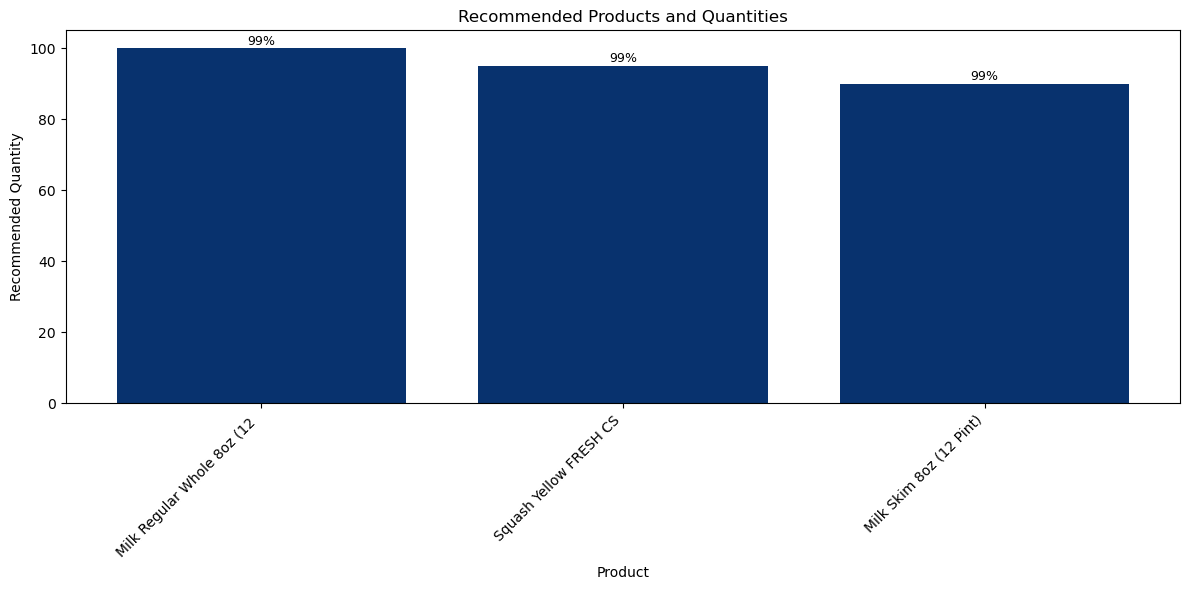

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


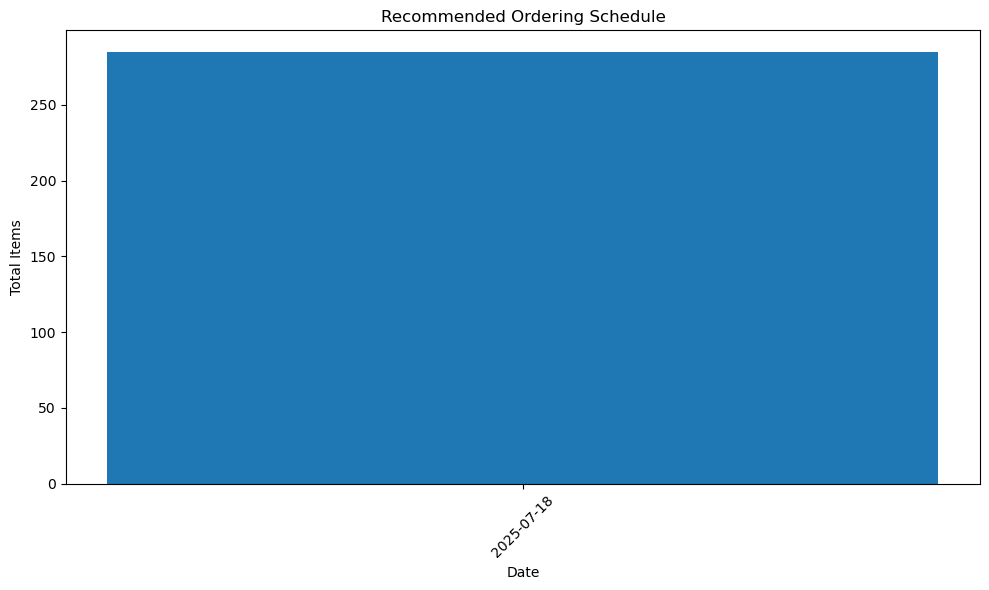

In [74]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boto3
from datetime import datetime, timedelta

# Define the prediction length
prediction_length = 14

# Function to test the endpoint with a single instance
def test_endpoint_with_instance(test_instance, endpoint_name=f"{endpoint_name}"):
    """Test the DeepAR endpoint with a single instance from test.json"""
    # Extract information from the test instance
    start_date = test_instance['start']
    target = test_instance['target']
    cat = test_instance['cat'] if 'cat' in test_instance else None
    item_id = test_instance.get('item_id', None)
    product_info = test_instance.get('product_info', {})
    
    # Parse the start date
    start_date_dt = pd.Timestamp(start_date)
    
    # Calculate the last date in the context window
    last_date = start_date_dt + pd.Timedelta(days=len(target)-1)
    
    # Generate future dates for the prediction period
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_length, freq='D')
    
    # Create dynamic features for the entire period (historical + prediction)
    if 'dynamic_feat' in test_instance:
        dynamic_feat = test_instance['dynamic_feat']
        extended_dynamic_feat = []
        
        for feat_idx, feat in enumerate(dynamic_feat):
            # Convert all values to float
            numeric_feat = [float(x) for x in feat]
            
            # Generate future values based on the feature index
            if feat_idx == 0:  # Day of week feature
                future_values = [float(d.dayofweek)/6 for d in future_dates]
            elif feat_idx == 1:  # Month feature
                future_values = [float(d.month-1)/11 for d in future_dates]
            else:
                # For other features, repeat the last value
                future_values = [float(numeric_feat[-1])] * prediction_length
            
            # Combine historical and future values
            extended_feat = numeric_feat + future_values
            extended_dynamic_feat.append(extended_feat)
    else:
        extended_dynamic_feat = None
    
    # Create the request payload - NOTE: Do not include NaN values in target
    request_instance = {
        "start": start_date,
        "target": [float(x) for x in target],  # Only include historical values
        "cat": cat
    }
    
    if extended_dynamic_feat:
        request_instance["dynamic_feat"] = extended_dynamic_feat
    
    request_payload = {
        "instances": [request_instance],
        "configuration": {
            "num_samples": 100,
            "output_types": ["quantiles"],
            "quantiles": ["0.1", "0.5", "0.9"]
        }
    }
    
    # Generate forecast
    try:
        # Use boto3 directly
        runtime = boto3.client('sagemaker-runtime')
        
        response = runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType='application/json',
            Body=json.dumps(request_payload)
        )
        
        # Parse the response
        result = json.loads(response['Body'].read().decode())
        predictions = result['predictions'][0]
        
        # Add item_id and product_info to predictions
        if item_id:
            predictions['item_id'] = item_id
        if product_info:
            predictions['product_info'] = product_info
        elif item_id and item_id in product_info_mapping:
            predictions['product_info'] = product_info_mapping[item_id]
        
        return predictions
        
    except Exception as e:
        print(f"❌ Error generating forecast: {str(e)}")
        print("Check the CloudWatch logs for more details.")
        return None

# Function to integrate with Amazon Bedrock
def integrate_with_bedrock(predictions_list, region_name='us-east-1'):
    """Generate business insights from predictions using Amazon Bedrock"""
    if not predictions_list:
        print("No predictions available for Bedrock integration")
        return None
    
    # Set up Bedrock client
    bedrock_client = boto3.client('bedrock-runtime', region_name=region_name)
    bedrock_model_id = 'anthropic.claude-3-sonnet-20240229-v1:0'  # You can change this to your preferred model

    
    # Prepare data for Bedrock
    product_predictions = []
    
    for i, pred in enumerate(predictions_list):
        # Extract predictions
        p50_values = pred['quantiles']['0.5']
        p10_values = pred['quantiles']['0.1']
        p90_values = pred['quantiles']['0.9']
        
        # Get product information
        product_info = pred.get('product_info', {})
        product_name = product_info.get('product_name', f"Product {i}")
        product_id = product_info.get('product_id', f"ID-{i}")
        category = product_info.get('category_name', 'Unknown')
        
        # Calculate average predicted quantity and trend
        avg_quantity = float(np.mean(p50_values))
        trend = "increasing" if p50_values[-1] > p50_values[0] else "decreasing"
        
        # Calculate volatility (standard deviation of predictions)
        volatility = float(np.std(p50_values))
        
        # Calculate confidence (inverse of the width of the confidence interval)
        confidence_width = float(np.mean(np.array(p90_values) - np.array(p10_values)))
        confidence_score = max(0, min(100, 100 - (confidence_width / avg_quantity * 100))) if avg_quantity > 0 else 50
        
        # Add to product predictions
        product_predictions.append({
            'product_name': product_name,
            'product_id': product_id,
            'category': category,
            'predicted_avg': avg_quantity,
            'p10_avg': float(np.mean(p10_values)),
            'p50_avg': float(np.mean(p50_values)),
            'p90_avg': float(np.mean(p90_values)),
            'trend': trend,
            'volatility': volatility,
            'confidence_score': confidence_score
        })
    
    # Create prompt for Bedrock
    current_date = datetime.now().strftime("%Y-%m-%d")
    
    prompt = f"""
    Based on the following product-level demand forecasts:
    
    Current date: {current_date}
    Product predictions: {json.dumps(product_predictions, indent=2)}
    
    Please provide intuitive business insights and actionable recommendations for procurement planning.
    
    For each product, consider:
    1. The predicted demand (p50_avg)
    2. The confidence in the prediction (confidence_score)
    3. The trend (increasing/decreasing)
    4. The volatility of demand
    5. The category of the product
    
    Please provide:
    1. Top products most likely to be ordered in the next forecast period
    2. Recommended order quantities for each product
    3. Optimal ordering schedule (which days to place orders)
    4. Seasonal or trend insights
    5. Risk assessment (products that might be over/under-stocked)
    6. Cost optimization suggestions
    
    Format your response as a JSON object:
    {{
      "recommended_products": [
        {{
          "product_name": "Actual Product Name",
          "product_id": "ID-X",
          "recommended_quantity": 5,
          "confidence": 85,
          "optimal_order_date": "YYYY-MM-DD",
          "reasoning": "explanation"
        }}
      ],
      "ordering_schedule": [
        {{
          "date": "YYYY-MM-DD",
          "products": ["Product A", "Product B"],
          "total_items": 15
        }}
      ],
      "insights": {{
        "seasonal_trends": "description",
        "risk_assessment": "description",
        "cost_optimization": "suggestions"
      }}
    }}
    """
    
    # Call Bedrock
    try:
        body = json.dumps({
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 2000,
            "temperature": 0.2,
            "messages": [
                {
                    "role": "user",
                    "content": prompt
                }
            ]
        })
        
        response = bedrock_client.invoke_model(
            modelId=bedrock_model_id,
            contentType='application/json',
            accept='application/json',
            body=body
        )
        
        response_body = json.loads(response['body'].read())
        response_text = response_body.get('content', [{}])[0].get('text', '')
        
        # Extract JSON from the response
        try:
            json_start = response_text.find('{')
            json_end = response_text.rfind('}') + 1
            if json_start >= 0 and json_end > json_start:
                json_str = response_text[json_start:json_end]
                recommendations = json.loads(json_str)
                
                # Save recommendations
                with open('bedrock_recommendations.json', 'w') as f:
                    json.dump(recommendations, f, indent=2)
                print("Bedrock recommendations saved to bedrock_recommendations.json")
                
                # Display insights
                if 'insights' in recommendations:
                    insights = recommendations['insights']
                    print("\n=== BUSINESS INSIGHTS ===")
                    print(f"\nSeasonal Trends:")
                    print(insights.get('seasonal_trends', 'No seasonal trends identified'))
                    
                    print(f"\nRisk Assessment:")
                    print(insights.get('risk_assessment', 'No risk assessment available'))
                    
                    print(f"\nCost Optimization:")
                    print(insights.get('cost_optimization', 'No cost optimization suggestions available'))
                
                # Display recommended products
                if 'recommended_products' in recommendations and recommendations['recommended_products']:
                    print("\n=== RECOMMENDED PRODUCTS ===")
                    for i, product in enumerate(recommendations['recommended_products']):
                        print(f"\n{i+1}. {product['product_name']}")
                        print(f"   Product ID: {product['product_id']}")
                        print(f"   Recommended Quantity: {product['recommended_quantity']}")
                        print(f"   Confidence: {product['confidence']}%")
                        print(f"   Optimal Order Date: {product['optimal_order_date']}")
                        print(f"   Reasoning: {product['reasoning']}")
                
                return recommendations
            else:
                raise ValueError("No JSON found in response")
        except Exception as json_error:
            print(f"Error parsing JSON from Bedrock response: {str(json_error)}")
            print(f"Raw response: {response_text}")
            return None
    except Exception as e:
        print(f"Error calling Bedrock: {str(e)}")
        return None

# Function to visualize Bedrock recommendations
def visualize_recommendations(recommendations):
    """Visualize the recommendations from Bedrock"""
    if not recommendations or 'recommended_products' not in recommendations:
        print("No recommendations available to visualize")
        return
    
    # Extract recommended products
    rec_products = recommendations['recommended_products']
    if not rec_products:
        print("No recommended products available")
        return
    
    # Create bar chart for recommended quantities
    plt.figure(figsize=(12, 6))
    
    # Sort by recommended quantity
    rec_products = sorted(rec_products, key=lambda x: x['recommended_quantity'], reverse=True)
    
    # Extract data for plotting
    product_names = [p['product_name'] for p in rec_products]
    quantities = [p['recommended_quantity'] for p in rec_products]
    confidence = [p['confidence'] for p in rec_products]
    
    # Create bar chart with confidence as color intensity
    bars = plt.bar(product_names, quantities, color=plt.cm.Blues(np.array(confidence)/100))
    
    # Add labels and title
    plt.title('Recommended Products and Quantities')
    plt.xlabel('Product')
    plt.ylabel('Recommended Quantity')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Add confidence as text on bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f"{confidence[i]}%", ha='center', va='bottom', fontsize=9)
    
    plt.show()
    
    # Display ordering schedule
    if 'ordering_schedule' in recommendations and recommendations['ordering_schedule']:
        plt.figure(figsize=(10, 6))
        
        # Extract data for plotting
        dates = [s['date'] for s in recommendations['ordering_schedule']]
        total_items = [s['total_items'] for s in recommendations['ordering_schedule']]
        
        # Create bar chart
        plt.bar(dates, total_items)
        
        # Add labels and title
        plt.title('Recommended Ordering Schedule')
        plt.xlabel('Date')
        plt.ylabel('Total Items')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        plt.show()

# Main function to run the entire pipeline
def run_deepar_bedrock_pipeline(num_instances=10):
    """Run the entire pipeline: DeepAR predictions + Bedrock insights"""
    # Load test data from test.json
    print("Loading test data from test.json...")
    with open('test.json', 'r') as f:
        test_instances = [json.loads(line) for line in f]

    print(f"Loaded {len(test_instances)} test instances")
    print(f"Testing with {num_instances} instances")
    
    # Get predictions for multiple instances
    all_predictions = []
    for i, test_instance in enumerate(test_instances[:num_instances]):
        print(f"\nProcessing instance {i+1}/{num_instances}")
        predictions = test_endpoint_with_instance(test_instance)
        if predictions:
            all_predictions.append(predictions)
    
    print(f"\nGenerated predictions for {len(all_predictions)} instances")
    
    # Generate Bedrock insights
    if all_predictions:
        print("\n=== GENERATING BUSINESS INSIGHTS WITH AMAZON BEDROCK ===")
        recommendations = integrate_with_bedrock(all_predictions)
        
        # Visualize recommendations
        visualize_recommendations(recommendations)
        
        return recommendations
    else:
        print("No predictions available for Bedrock integration")
        return None

# Run the pipeline if executed directly
if __name__ == "__main__":
    run_deepar_bedrock_pipeline(num_instances=5)  # Process 5 instances

Loading test data...
Loading train data...
Loaded product information for 34950 items
Loaded 34950 test instances and 34950 train instances
Evaluating 5 test instances

Evaluating test instance 1/5
Found product: Bottle Deposit 1
Bottle Deposit 1 Metrics:
  RMSE: 0.0006
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan

Insights for Bottle Deposit 1:
  • Average predicted demand: 1.0 units
  • Demand trend: increasing
  • Prediction confidence: 99.8% (lower is less certain)
  • Recommendation: Consider increasing inventory levels


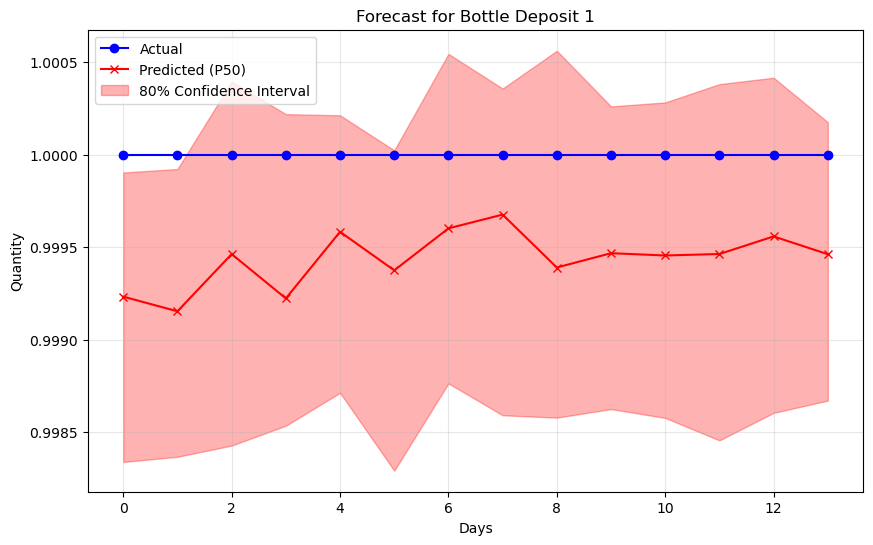


Evaluating test instance 2/5
Found product: Squash Yellow FRESH CS
Squash Yellow FRESH CS Metrics:
  RMSE: 0.0006
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan

Insights for Squash Yellow FRESH CS:
  • Average predicted demand: 1.0 units
  • Demand trend: increasing
  • Prediction confidence: 99.8% (lower is less certain)
  • Recommendation: Consider increasing inventory levels


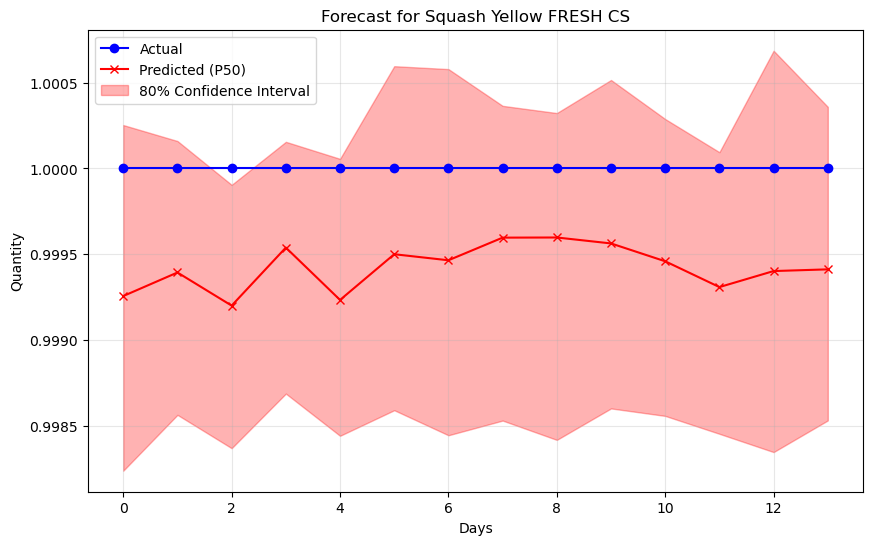


Evaluating test instance 3/5
Found product: Milk Regular Whole 8oz (12 
Milk Regular Whole 8oz (12  Metrics:
  RMSE: 0.0006
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan

Insights for Milk Regular Whole 8oz (12 :
  • Average predicted demand: 1.0 units
  • Demand trend: increasing
  • Prediction confidence: 99.8% (lower is less certain)
  • Recommendation: Consider increasing inventory levels


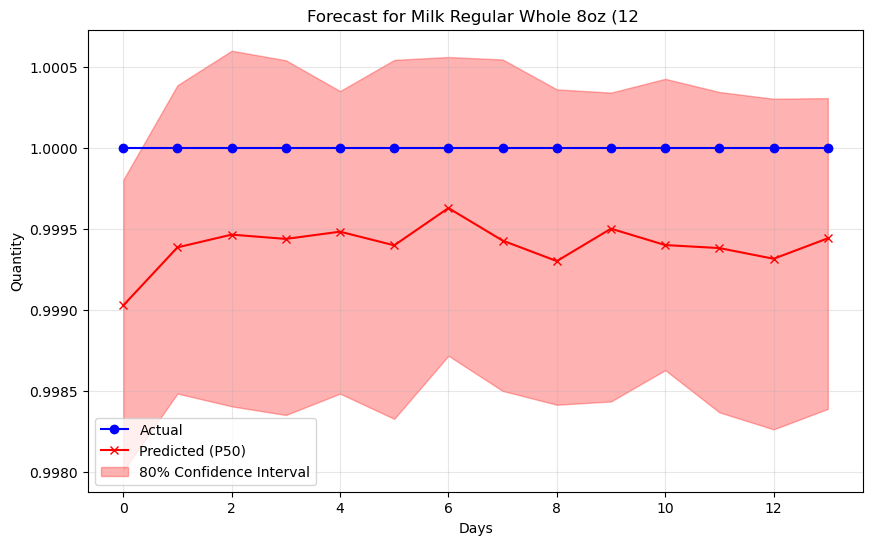


Evaluating test instance 4/5
Found product: Milk Skim 8oz (12 Pint)
Milk Skim 8oz (12 Pint) Metrics:
  RMSE: 0.0006
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan

Insights for Milk Skim 8oz (12 Pint):
  • Average predicted demand: 1.0 units
  • Demand trend: increasing
  • Prediction confidence: 99.8% (lower is less certain)
  • Recommendation: Consider increasing inventory levels


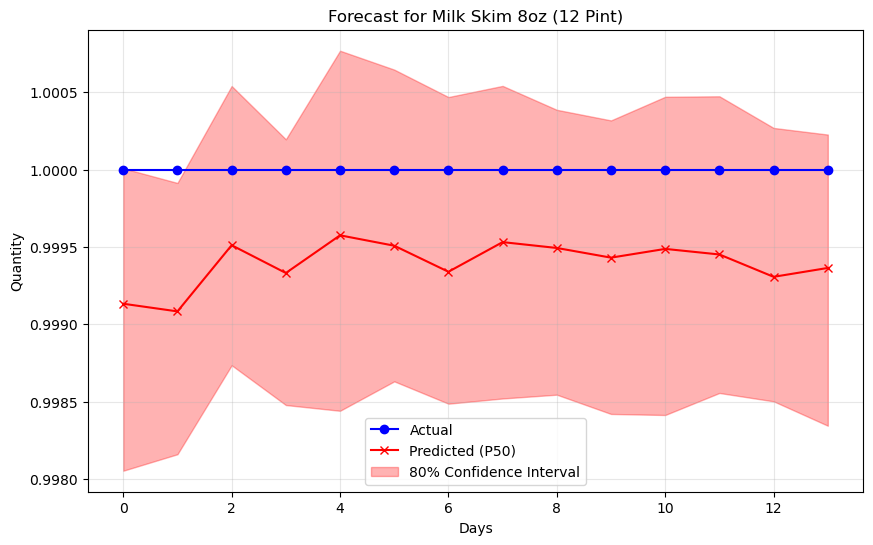


Evaluating test instance 5/5
Found product: Milk Regular Whole 4oz
Milk Regular Whole 4oz Metrics:
  RMSE: 0.0006
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan

Insights for Milk Regular Whole 4oz:
  • Average predicted demand: 1.0 units
  • Demand trend: increasing
  • Prediction confidence: 99.8% (lower is less certain)
  • Recommendation: Consider increasing inventory levels


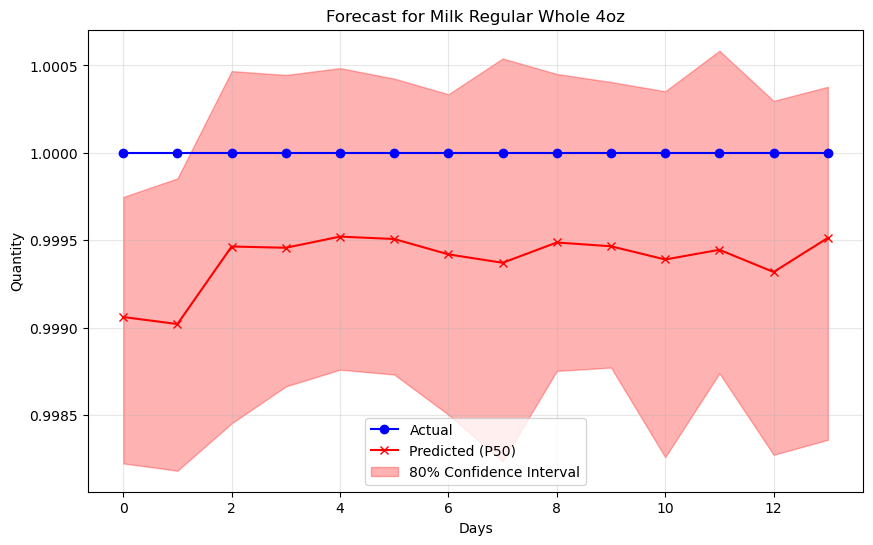


===== Overall Model Performance =====
Aggregate RMSE: 0.0006
Aggregate MAPE: 0.06%
Aggregate MAE: 0.0006
Aggregate MASE: nan


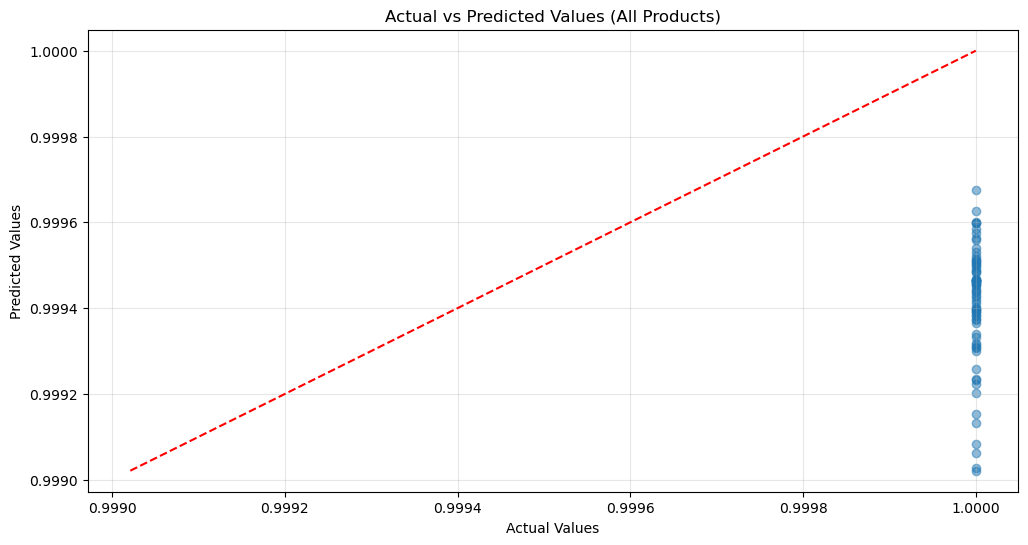

Results saved to model_evaluation_results.json
Error calling Bedrock: An error occurred (AccessDeniedException) when calling the InvokeModel operation: You don't have access to the model with the specified model ID.


In [75]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boto3
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the prediction length
prediction_length = 14

def calculate_accuracy_metrics(actual_values, predicted_values):
    """Calculate common accuracy metrics for time series forecasting"""
    # Root Mean Square Error
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    
    # Mean Absolute Percentage Error - handle zero values to avoid division by zero
    non_zero_idx = actual_values != 0
    if np.any(non_zero_idx):
        mape = np.mean(np.abs((actual_values[non_zero_idx] - predicted_values[non_zero_idx]) / actual_values[non_zero_idx])) * 100
    else:
        mape = np.nan
    
    # Mean Absolute Error
    mae = mean_absolute_error(actual_values, predicted_values)
    
    # Mean Absolute Scaled Error (MASE)
    if len(actual_values) > 1:
        naive_errors = np.abs(np.diff(actual_values))
        if np.sum(naive_errors) > 0:
            mase = mean_absolute_error(actual_values, predicted_values) / np.mean(naive_errors)
        else:
            mase = np.nan
    else:
        mase = np.nan
    
    return {
        'RMSE': rmse,
        'MAPE': mape,
        'MAE': mae,
        'MASE': mase
    }

def get_predictions_from_endpoint(test_instance, endpoint_name=f"{endpoint_name}"):
    """Get predictions from the DeepAR endpoint for a test instance"""
    # Extract information from the test instance
    start_date = test_instance['start']
    target = test_instance['target']
    cat = test_instance['cat'] if 'cat' in test_instance else None
    
    # Parse the start date
    start_date_dt = pd.Timestamp(start_date)
    
    # Calculate the last date in the context window
    last_date = start_date_dt + pd.Timedelta(days=len(target)-1)
    
    # Generate future dates for the prediction period
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_length, freq='D')
    
    # Create dynamic features for the entire period (historical + prediction)
    if 'dynamic_feat' in test_instance:
        dynamic_feat = test_instance['dynamic_feat']
        extended_dynamic_feat = []
        
        for feat_idx, feat in enumerate(dynamic_feat):
            # Convert all values to float
            numeric_feat = [float(x) for x in feat]
            
            # Generate future values based on the feature index
            if feat_idx == 0:  # Day of week feature
                future_values = [float(d.dayofweek)/6 for d in future_dates]
            elif feat_idx == 1:  # Month feature
                future_values = [float(d.month-1)/11 for d in future_dates]
            else:
                # For other features, repeat the last value
                future_values = [float(numeric_feat[-1])] * prediction_length
            
            # Combine historical and future values
            extended_feat = numeric_feat + future_values
            extended_dynamic_feat.append(extended_feat)
    else:
        extended_dynamic_feat = None
    
    # Create the request payload - NOTE: Do not include NaN values in target
    request_instance = {
        "start": start_date,
        "target": [float(x) for x in target],  # Only include historical values
        "cat": cat
    }
    
    if extended_dynamic_feat:
        request_instance["dynamic_feat"] = extended_dynamic_feat
    
    request_payload = {
        "instances": [request_instance],
        "configuration": {
            "num_samples": 100,
            "output_types": ["quantiles"],
            "quantiles": ["0.1", "0.5", "0.9"]
        }
    }
    
    # Generate forecast
    try:
        # Use boto3 directly
        runtime = boto3.client('sagemaker-runtime')
        
        response = runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType='application/json',
            Body=json.dumps(request_payload)
        )
        
        # Parse the response
        result = json.loads(response['Body'].read().decode())
        predictions = result['predictions'][0]
        
        return predictions
        
    except Exception as e:
        print(f"❌ Error generating forecast: {str(e)}")
        return None

def load_product_info_mapping(path='product_info_mapping.json'):
    """Load product information mapping from a JSON file"""
    try:
        with open(path, 'r') as f:
            item_to_product_info = json.load(f)
        print(f"Loaded product information for {len(item_to_product_info)} items")
        return item_to_product_info
    except Exception as e:
        print(f"Warning: Could not load product information mapping: {str(e)}")
        return {}

def evaluate_model_accuracy(test_file='test.json', train_file='train.json', num_instances=10, product_info_file='product_info_mapping.json'):
    """Evaluate model accuracy using test data with actual product names"""
    print("Loading test data...")
    with open(test_file, 'r') as f:
        test_instances = [json.loads(line) for line in f]
    
    print("Loading train data...")
    with open(train_file, 'r') as f:
        train_instances = [json.loads(line) for line in f]
    
    # Load product information mapping
    product_info_mapping = load_product_info_mapping(product_info_file)
    
    print(f"Loaded {len(test_instances)} test instances and {len(train_instances)} train instances")
    print(f"Evaluating {min(num_instances, len(test_instances))} test instances")
    
    # Store results
    results = []
    all_actuals = []
    all_predictions = []
    
    # Process test instances
    for i, test_instance in enumerate(test_instances[:num_instances]):
        print(f"\nEvaluating test instance {i+1}/{min(num_instances, len(test_instances))}")
        
        # Find matching train instance to get the full time series
        matching_train = None
        for train_instance in train_instances:
            if (train_instance['start'] == test_instance['start'] and 
                'cat' in train_instance and 'cat' in test_instance and
                train_instance['cat'] == test_instance['cat']):
                matching_train = train_instance
                break
        
        if not matching_train:
            print(f"No matching train instance found for test instance {i+1}")
            continue
        
        # Get product information
        product_info = {}
        item_id = test_instance.get('item_id', None)
        
        if item_id and item_id in product_info_mapping:
            product_info = product_info_mapping[item_id]
            product_name = product_info.get('product_name', f"Product {i+1}")
            print(f"Found product: {product_name}")
        elif 'product_info' in test_instance:
            product_info = test_instance['product_info']
            product_name = product_info.get('product_name', f"Product {i+1}")
            print(f"Using embedded product info: {product_name}")
        else:
            product_name = f"Product {i+1}"
            print(f"No product information found, using generic name: {product_name}")
        
        # Get predictions from the endpoint
        predictions = get_predictions_from_endpoint(test_instance)
        if not predictions:
            print(f"Failed to get predictions for test instance {i+1}")
            continue
        
        # Extract the actual values for the prediction period
        # The test instance has the context window, and the train instance has the full time series
        test_target_len = len(test_instance['target'])
        train_target_len = len(matching_train['target'])
        
        # Check if train instance has enough data for the prediction period
        if train_target_len < test_target_len + prediction_length:
            print(f"Train instance doesn't have enough data for the prediction period")
            continue
        
        # Extract actual values for the prediction period
        actual_values = np.array(matching_train['target'][test_target_len:test_target_len + prediction_length])
        
        # Extract predicted values (p50)
        predicted_values = np.array(predictions['quantiles']['0.5'])
        
        # Calculate metrics
        metrics = calculate_accuracy_metrics(actual_values, predicted_values)
        
        # Store results with product information
        result = {
            'instance_index': i,
            'item_id': item_id,
            'product_info': product_info,
            'metrics': metrics,
            'actual_values': actual_values.tolist(),
            'predicted_values': predicted_values.tolist(),
            'p10_values': np.array(predictions['quantiles']['0.1']).tolist(),
            'p90_values': np.array(predictions['quantiles']['0.9']).tolist()
        }
        results.append(result)
        
        # Add to aggregate metrics
        all_actuals.extend(actual_values)
        all_predictions.extend(predicted_values)
        
        # Print metrics with product name
        print(f"{product_name} Metrics:")
        print(f"  RMSE: {metrics['RMSE']:.4f}")
        print(f"  MAPE: {metrics['MAPE']:.2f}%")
        print(f"  MAE: {metrics['MAE']:.4f}")
        print(f"  MASE: {metrics['MASE']:.4f}")
        
        # Calculate trend
        trend = "increasing" if predicted_values[-1] > predicted_values[0] else "decreasing"
        avg_prediction = np.mean(predicted_values)
        confidence_width = np.mean(np.array(predictions['quantiles']['0.9']) - np.array(predictions['quantiles']['0.1']))
        
        # Print intuitive insights
        print(f"\nInsights for {product_name}:")
        print(f"  • Average predicted demand: {avg_prediction:.1f} units")
        print(f"  • Demand trend: {trend}")
        print(f"  • Prediction confidence: {100 - (confidence_width/avg_prediction*100):.1f}% (lower is less certain)")
        
        if trend == "increasing":
            print(f"  • Recommendation: Consider increasing inventory levels")
        else:
            print(f"  • Recommendation: Monitor inventory to avoid overstocking")
        
        # Plot actual vs predicted with product name
        plt.figure(figsize=(10, 6))
        plt.plot(range(prediction_length), actual_values, 'b-', label='Actual', marker='o')
        plt.plot(range(prediction_length), predicted_values, 'r-', label='Predicted (P50)', marker='x')
        plt.fill_between(
            range(prediction_length),
            predictions['quantiles']['0.1'],
            predictions['quantiles']['0.9'],
            color='r',
            alpha=0.3,
            label='80% Confidence Interval'
        )
        plt.title(f'Forecast for {product_name}')
        plt.xlabel('Days')
        plt.ylabel('Quantity')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # Calculate aggregate metrics
    if all_actuals and all_predictions:
        aggregate_metrics = calculate_accuracy_metrics(np.array(all_actuals), np.array(all_predictions))
        
        print("\n===== Overall Model Performance =====")
        print(f"Aggregate RMSE: {aggregate_metrics['RMSE']:.4f}")
        print(f"Aggregate MAPE: {aggregate_metrics['MAPE']:.2f}%")
        print(f"Aggregate MAE: {aggregate_metrics['MAE']:.4f}")
        print(f"Aggregate MASE: {aggregate_metrics['MASE']:.4f}")
        
        # Plot overall actual vs predicted
        plt.figure(figsize=(12, 6))
        plt.scatter(all_actuals, all_predictions, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(min(all_actuals), min(all_predictions))
        max_val = max(max(all_actuals), max(all_predictions))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.title('Actual vs Predicted Values (All Products)')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Save results
        with open('model_evaluation_results.json', 'w') as f:
            json.dump({
                'individual_results': results,
                'aggregate_metrics': aggregate_metrics
            }, f, indent=2)
        
        print("Results saved to model_evaluation_results.json")
        
        return aggregate_metrics, results
    else:
        print("No valid results to calculate aggregate metrics")
        return None, []

def integrate_with_bedrock(evaluation_results, region_name='us-east-1'):
    """Generate intuitive business insights from model evaluation results using Amazon Bedrock"""
    if not evaluation_results or not evaluation_results[1]:
        print("No evaluation results available for Bedrock integration")
        return None
    
    # Set up Bedrock client
    bedrock_client = boto3.client('bedrock-runtime', region_name=region_name)
    bedrock_model_id = 'anthropic.claude-3-sonnet-20240229-v1:0'
    
    # Extract results
    results = evaluation_results[1]
    aggregate_metrics = evaluation_results[0]
    
    # Prepare product-level insights
    product_insights = []
    for result in results:
        product_info = result.get('product_info', {})
        product_name = product_info.get('product_name', f"Product {result['instance_index']}")
        category = product_info.get('category_name', 'Unknown')
        
        # Calculate trend and volatility
        predicted = result['predicted_values']
        trend = "increasing" if predicted[-1] > predicted[0] else "decreasing"
        volatility = np.std(predicted) / np.mean(predicted) if np.mean(predicted) > 0 else 0
        
        # Calculate confidence
        p10 = result['p10_values']
        p90 = result['p90_values']
        confidence_width = np.mean(np.array(p90) - np.array(p10))
        avg_prediction = np.mean(predicted)
        confidence = 100 - (confidence_width/avg_prediction*100) if avg_prediction > 0 else 0
        
        product_insights.append({
            'product_name': product_name,
            'product_id': product_info.get('product_id', f"ID-{result['instance_index']}"),
            'category': category,
            'metrics': result['metrics'],
            'trend': trend,
            'volatility': float(volatility),
            'confidence': float(confidence),
            'avg_prediction': float(avg_prediction),
            'max_prediction': float(np.max(predicted)),
            'min_prediction': float(np.min(predicted))
        })
    
    # Create prompt for Bedrock
    current_date = datetime.now().strftime("%Y-%m-%d")
    
    prompt = f"""
    Based on the following product-level forecasting results:
    
    Current date: {current_date}
    
    Aggregate Metrics:
    - RMSE: {aggregate_metrics['RMSE']:.4f}
    - MAPE: {aggregate_metrics['MAPE']:.2f}%
    - MAE: {aggregate_metrics['MAE']:.4f}
    - MASE: {aggregate_metrics['MASE']:.4f}
    
    Product-Level Insights:
    {json.dumps(product_insights, indent=2)}
    
    Please provide:
    1. A brief summary of overall demand patterns
    2. Specific procurement recommendations for each product
    3. Suggested order quantities and timing for each product
    4. Risk assessment for stock levels based on prediction confidence
    5. Prioritized list of products to focus on for inventory management
    
    Format your response in a conversational, intuitive way that a procurement manager would find helpful. Focus on actionable insights rather than technical details.
    """
    
    # Call Bedrock
    try:
        body = json.dumps({
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 2000,
            "temperature": 0.2,
            "messages": [
                {
                    "role": "user",
                    "content": prompt
                }
            ]
        })
        
        response = bedrock_client.invoke_model(
            modelId=bedrock_model_id,
            contentType='application/json',
            accept='application/json',
            body=body
        )
        
        response_body = json.loads(response['body'].read())
        response_text = response_body.get('content', [{}])[0].get('text', '')
        
        print("\n===== BEDROCK INSIGHTS =====\n")
        print(response_text)
        
        # Save insights
        with open('bedrock_procurement_insights.txt', 'w') as f:
            f.write(response_text)
        print("\nInsights saved to bedrock_procurement_insights.txt")
        
        return response_text
    except Exception as e:
        print(f"Error calling Bedrock: {str(e)}")
        return None

# Run the evaluation and Bedrock integration if executed directly
if __name__ == "__main__":
    evaluation_results = evaluate_model_accuracy(num_instances=5)  # Evaluate 5 instances
    if evaluation_results and evaluation_results[0]:
        integrate_with_bedrock(evaluation_results)

In [76]:
def evaluate_model_accuracy(test_file='test.json', train_file='train.json', num_instances=10):
    """Evaluate model accuracy using test data"""
    print("Loading test data...")
    with open(test_file, 'r') as f:
        test_instances = [json.loads(line) for line in f]
    
    print("Loading train data...")
    with open(train_file, 'r') as f:
        train_instances = [json.loads(line) for line in f]
    
    print(f"Loaded {len(test_instances)} test instances and {len(train_instances)} train instances")
    print(f"Evaluating {min(num_instances, len(test_instances))} test instances")
    
    # Store results
    results = []
    all_actuals = []
    all_predictions = []
    
    # Process test instances
    for i, test_instance in enumerate(test_instances[:num_instances]):
        print(f"\nEvaluating test instance {i+1}/{min(num_instances, len(test_instances))}")
        
        # Find matching train instance to get the full time series
        matching_train = None
        for train_instance in train_instances:
            if (train_instance['start'] == test_instance['start'] and 
                'cat' in train_instance and 'cat' in test_instance and
                train_instance['cat'] == test_instance['cat']):
                matching_train = train_instance
                break
        
        if not matching_train:
            print(f"No matching train instance found for test instance {i+1}")
            continue
        
        # Get predictions from the endpoint
        predictions = get_predictions_from_endpoint(test_instance)
        if not predictions:
            print(f"Failed to get predictions for test instance {i+1}")
            continue
        
        # Extract the actual values for the prediction period
        # The test instance has the context window, and the train instance has the full time series
        test_target_len = len(test_instance['target'])
        train_target_len = len(matching_train['target'])
        
        # Check if train instance has enough data for the prediction period
        if train_target_len < test_target_len + prediction_length:
            print(f"Train instance doesn't have enough data for the prediction period")
            continue
        
        # Extract actual values for the prediction period
        actual_values = np.array(matching_train['target'][test_target_len:test_target_len + prediction_length])
        
        # Extract predicted values (p50)
        predicted_values = np.array(predictions['quantiles']['0.5'])
        
        # Calculate metrics
        metrics = calculate_accuracy_metrics(actual_values, predicted_values)
        
        # Store results
        results.append({
            'instance_index': i,
            'metrics': metrics,
            'actual_values': actual_values.tolist(),
            'predicted_values': predicted_values.tolist(),
            'p10_values': np.array(predictions['quantiles']['0.1']).tolist(),
            'p90_values': np.array(predictions['quantiles']['0.9']).tolist()
        })
        
        # Add to aggregate metrics
        all_actuals.extend(actual_values)
        all_predictions.extend(predicted_values)
        
        # Print metrics
        print(f"Instance {i+1} Metrics:")
        print(f"  RMSE: {metrics['RMSE']:.4f}")
        print(f"  MAPE: {metrics['MAPE']:.2f}%")
        print(f"  MAE: {metrics['MAE']:.4f}")
        print(f"  MASE: {metrics['MASE']:.4f}")
        
        # Plot actual vs predicted
        plt.figure(figsize=(10, 6))
        plt.plot(range(prediction_length), actual_values, 'b-', label='Actual', marker='o')
        plt.plot(range(prediction_length), predicted_values, 'r-', label='Predicted (P50)', marker='x')
        plt.fill_between(
            range(prediction_length),
            predictions['quantiles']['0.1'],
            predictions['quantiles']['0.9'],
            color='r',
            alpha=0.3,
            label='80% Confidence Interval'
        )
        plt.title(f'Actual vs Predicted for Instance {i+1}')
        plt.xlabel('Days')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # Calculate aggregate metrics
    if all_actuals and all_predictions:
        aggregate_metrics = calculate_accuracy_metrics(np.array(all_actuals), np.array(all_predictions))
        
        print("\n===== Overall Model Performance =====")
        print(f"Aggregate RMSE: {aggregate_metrics['RMSE']:.4f}")
        print(f"Aggregate MAPE: {aggregate_metrics['MAPE']:.2f}%")
        print(f"Aggregate MAE: {aggregate_metrics['MAE']:.4f}")
        print(f"Aggregate MASE: {aggregate_metrics['MASE']:.4f}")
        
        # Plot overall actual vs predicted
        plt.figure(figsize=(12, 6))
        plt.scatter(all_actuals, all_predictions, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(min(all_actuals), min(all_predictions))
        max_val = max(max(all_actuals), max(all_predictions))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.title('Actual vs Predicted Values (All Test Instances)')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Create the complete evaluation results structure
        evaluation_results = {
            'individual_results': results,
            'aggregate_metrics': aggregate_metrics
        }
        
        # Save results
        with open('model_evaluation_results.json', 'w') as f:
            json.dump(evaluation_results, f, indent=2)
        
        print("Results saved to model_evaluation_results.json")
        
        return evaluation_results
    else:
        print("No valid results to calculate aggregate metrics")
        return None

In [77]:
def evaluate_model_accuracy_with_bedrock(test_file='test.json', train_file='train.json', num_instances=10):
    """Evaluate model accuracy using test data and integrate with Bedrock for insights"""
    # Run the original evaluation
    evaluation_results = evaluate_model_accuracy(test_file, train_file, num_instances)
    
    # Check if we have valid evaluation results
    if evaluation_results is None:
        print("No evaluation results available for Bedrock integration")
        return None
    
    # Integrate with Bedrock
    print("\n=== INTEGRATING WITH AMAZON BEDROCK FOR BUSINESS INSIGHTS ===")
    insights = integrate_with_bedrock(evaluation_results)
    
    # Visualize insights
    if insights:
        visualize_bedrock_insights(insights)
    
    return insights

Loading test data...
Loading train data...
Loaded 34950 test instances and 34950 train instances
Evaluating 5 test instances

Evaluating test instance 1/5
Instance 1 Metrics:
  RMSE: 0.0006
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan


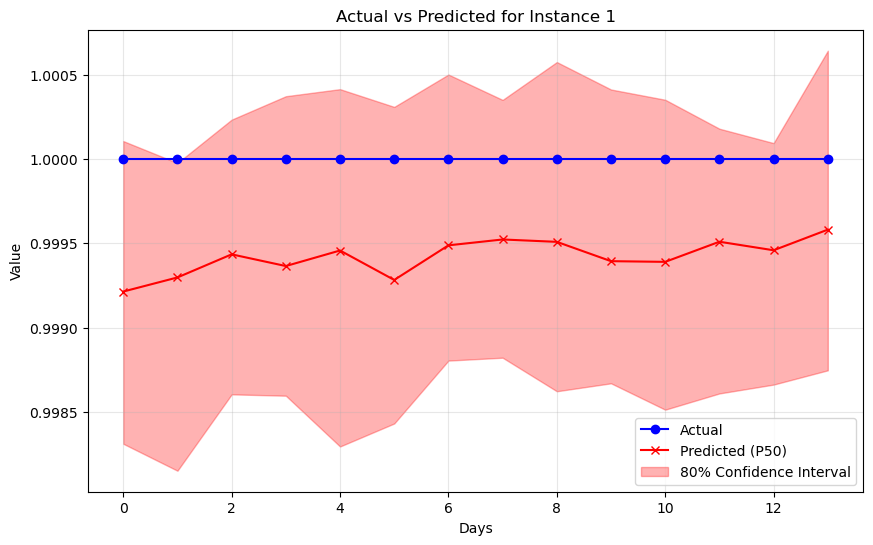


Evaluating test instance 2/5
Instance 2 Metrics:
  RMSE: 0.0006
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan


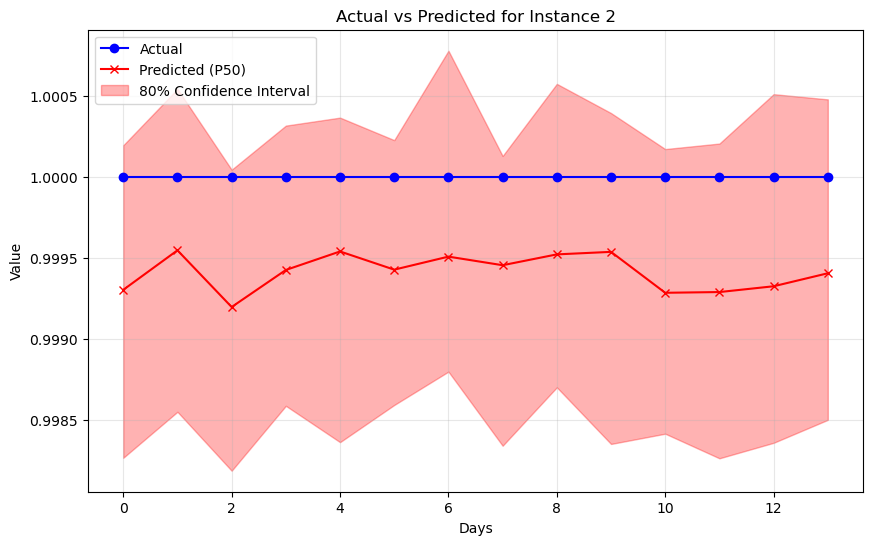


Evaluating test instance 3/5
Instance 3 Metrics:
  RMSE: 0.0006
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan


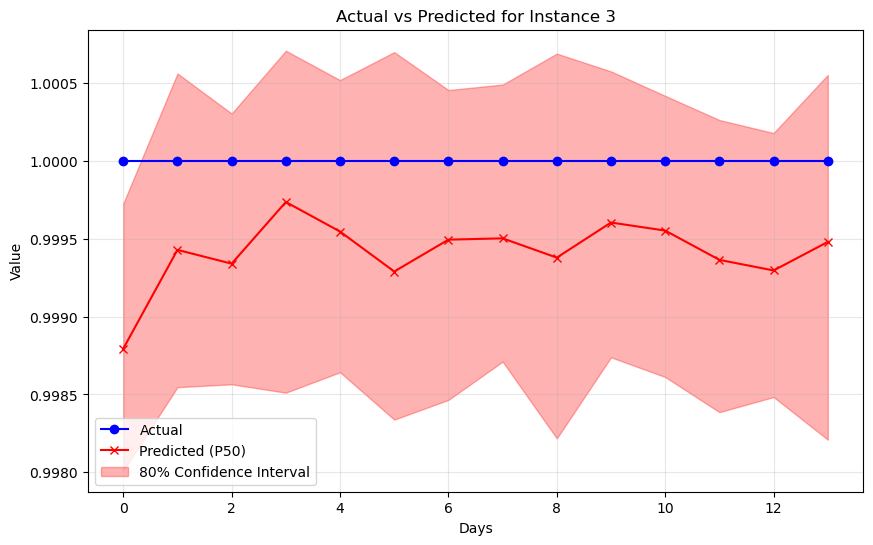


Evaluating test instance 4/5
Instance 4 Metrics:
  RMSE: 0.0006
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan


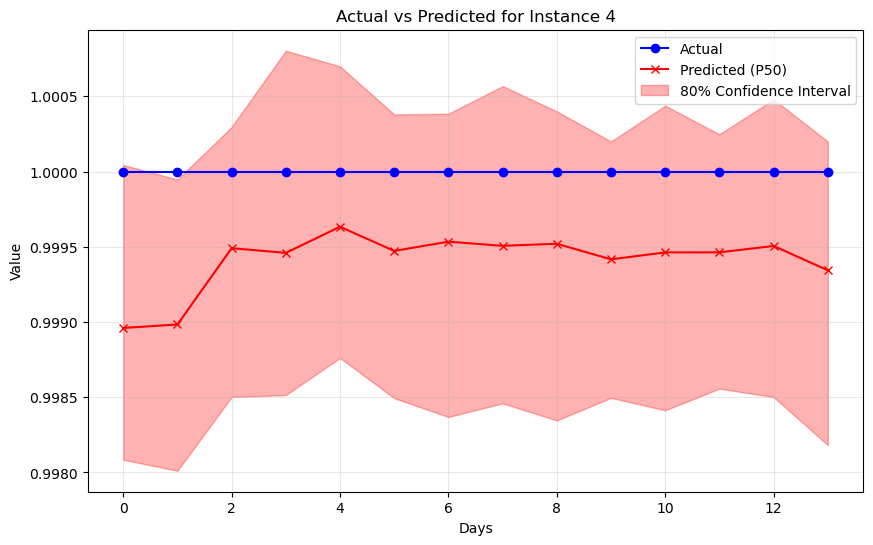


Evaluating test instance 5/5
Instance 5 Metrics:
  RMSE: 0.0006
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan


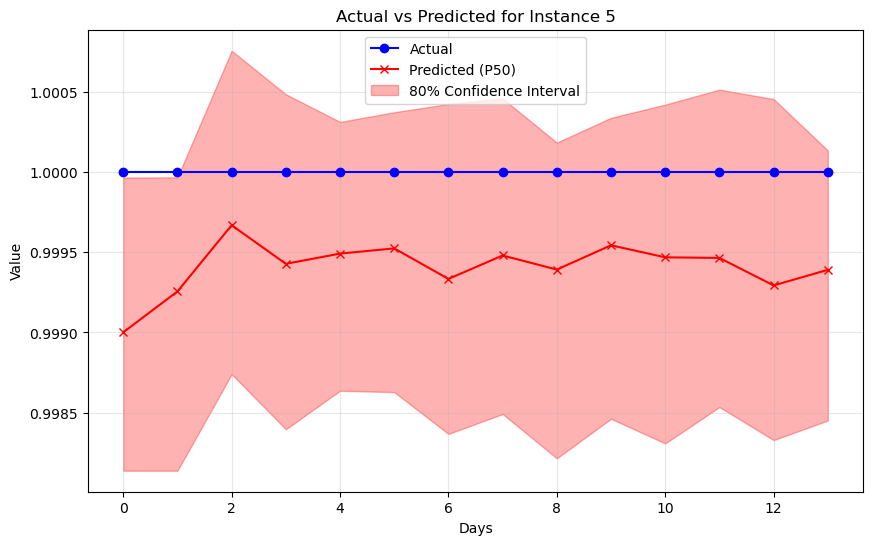


===== Overall Model Performance =====
Aggregate RMSE: 0.0006
Aggregate MAPE: 0.06%
Aggregate MAE: 0.0006
Aggregate MASE: nan


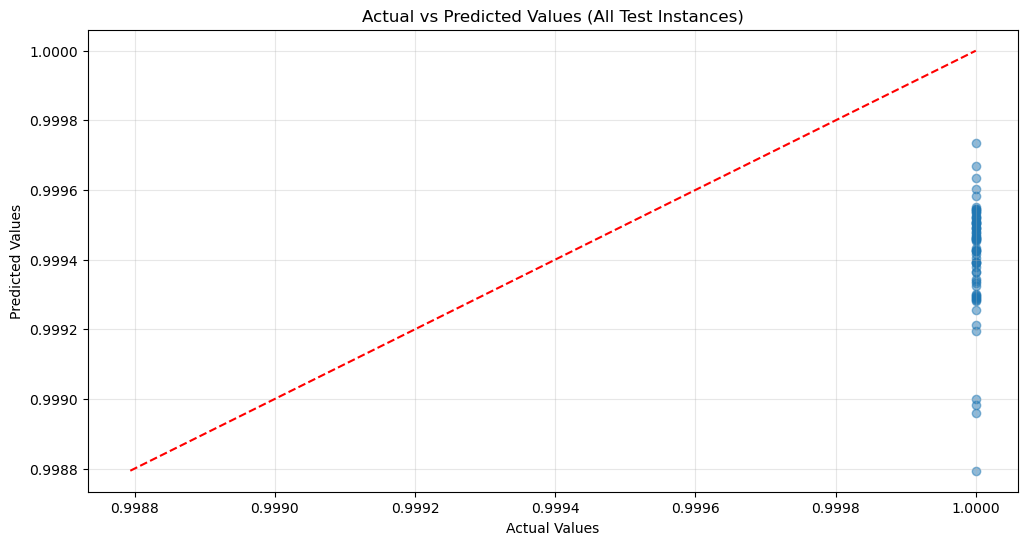

Results saved to model_evaluation_results.json

=== INTEGRATING WITH AMAZON BEDROCK FOR BUSINESS INSIGHTS ===
Bedrock insights saved to bedrock_model_insights.json

=== MODEL ANALYSIS ===

Performance Summary:
The model demonstrates excellent performance with very low error metrics (RMSE around 0.0006, MAPE around 0.06%, and MAE around 0.0006). This indicates that the forecasts are highly accurate and closely match the actual values.

Strengths:
- Low error rates across multiple metrics
- Consistent performance across different instances

Weaknesses:
- MASE values are not available, making it difficult to assess the model's performance relative to a naive forecast
- Limited information on the data characteristics and model assumptions

Improvement Suggestions:
- Investigate the reasons for the missing MASE values and address any underlying issues
- Explore additional features or external data sources that could further improve the model's accuracy
- Conduct sensitivity analysis to unde

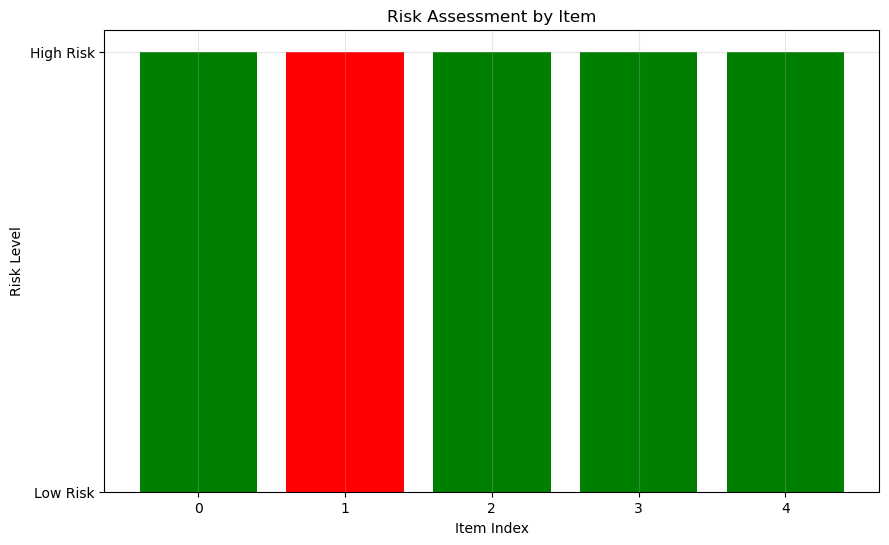

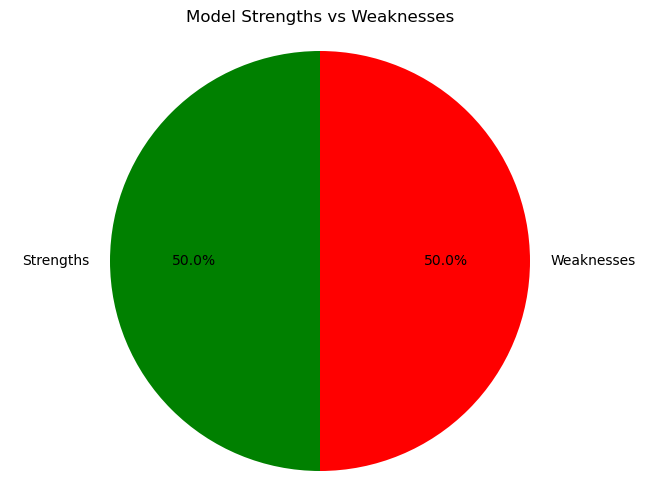

In [79]:
def integrate_with_bedrock(evaluation_results, region_name='us-east-1'):
    """Generate business insights from model evaluation results using Amazon Bedrock"""
    if not evaluation_results or 'individual_results' not in evaluation_results:
        print("No evaluation results available for Bedrock integration")
        return None
    
    # Set up Bedrock client
    bedrock_client = boto3.client('bedrock-runtime', region_name=region_name)
    bedrock_model_id = 'anthropic.claude-3-sonnet-20240229-v1:0'
    
    # Prepare data for Bedrock
    individual_results = evaluation_results['individual_results']
    aggregate_metrics = evaluation_results['aggregate_metrics']
    
    # Create prompt for Bedrock
    current_date = datetime.now().strftime("%Y-%m-%d")
    
    prompt = f"""
    Based on the following time series forecasting model evaluation results:
    
    Current date: {current_date}
    
    Aggregate Metrics:
    - RMSE: {aggregate_metrics['RMSE']:.4f}
    - MAPE: {aggregate_metrics['MAPE']:.2f}%
    - MAE: {aggregate_metrics['MAE']:.4f}
    - MASE: {aggregate_metrics['MASE']:.4f}
    
    Individual Results:
    {json.dumps(individual_results[:5], indent=2)}  # Showing first 5 results for brevity
    
    Please provide:
    1. Analysis of model performance and accuracy
    2. Recommendations for model improvement
    3. Business insights based on the forecasting results
    4. Suggested actions for inventory management and procurement
    5. Risk assessment for stock levels based on prediction confidence intervals
    
    Format your response as a JSON object:
    {{
      "model_analysis": {{
        "performance_summary": "description",
        "strengths": ["strength1", "strength2"],
        "weaknesses": ["weakness1", "weakness2"],
        "improvement_suggestions": ["suggestion1", "suggestion2"]
      }},
      "business_insights": {{
        "trends": "description",
        "seasonal_patterns": "description",
        "anomalies": "description"
      }},
      "procurement_recommendations": [
        {{
          "instance_index": 0,
          "recommendation": "specific recommendation",
          "reasoning": "explanation"
        }}
      ],
      "risk_assessment": {{
        "high_risk_items": [0, 1],  # instance indices
        "low_risk_items": [2, 3],   # instance indices
        "overall_risk_level": "description"
      }}
    }}
    """
    
    # Call Bedrock
    try:
        body = json.dumps({
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 2000,
            "temperature": 0.2,
            "messages": [
                {
                    "role": "user",
                    "content": prompt
                }
            ]
        })
        
        response = bedrock_client.invoke_model(
            modelId=bedrock_model_id,
            contentType='application/json',
            accept='application/json',
            body=body
        )
        
        response_body = json.loads(response['body'].read())
        response_text = response_body.get('content', [{}])[0].get('text', '')
        
        # Extract JSON from the response
        try:
            json_start = response_text.find('{')
            json_end = response_text.rfind('}') + 1
            if json_start >= 0 and json_end > json_start:
                json_str = response_text[json_start:json_end]
                insights = json.loads(json_str)
                
                # Save insights
                with open('bedrock_model_insights.json', 'w') as f:
                    json.dump(insights, f, indent=2)
                print("Bedrock insights saved to bedrock_model_insights.json")
                
                # Display insights
                print("\n=== MODEL ANALYSIS ===")
                if 'model_analysis' in insights:
                    analysis = insights['model_analysis']
                    print(f"\nPerformance Summary:")
                    print(analysis.get('performance_summary', 'No summary available'))
                    
                    print(f"\nStrengths:")
                    for strength in analysis.get('strengths', []):
                        print(f"- {strength}")
                    
                    print(f"\nWeaknesses:")
                    for weakness in analysis.get('weaknesses', []):
                        print(f"- {weakness}")
                    
                    print(f"\nImprovement Suggestions:")
                    for suggestion in analysis.get('improvement_suggestions', []):
                        print(f"- {suggestion}")
                
                print("\n=== BUSINESS INSIGHTS ===")
                if 'business_insights' in insights:
                    business = insights['business_insights']
                    print(f"\nTrends:")
                    print(business.get('trends', 'No trends identified'))
                    
                    print(f"\nSeasonal Patterns:")
                    print(business.get('seasonal_patterns', 'No seasonal patterns identified'))
                    
                    print(f"\nAnomalies:")
                    print(business.get('anomalies', 'No anomalies identified'))
                
                print("\n=== PROCUREMENT RECOMMENDATIONS ===")
                if 'procurement_recommendations' in insights:
                    for rec in insights['procurement_recommendations']:
                        print(f"\nItem {rec.get('instance_index', 'Unknown')}:")
                        print(f"  Recommendation: {rec.get('recommendation', 'No recommendation')}")
                        print(f"  Reasoning: {rec.get('reasoning', 'No reasoning provided')}")
                
                return insights
            else:
                raise ValueError("No JSON found in response")
        except Exception as json_error:
            print(f"Error parsing JSON from Bedrock response: {str(json_error)}")
            print(f"Raw response: {response_text}")
            return None
    except Exception as e:
        print(f"Error calling Bedrock: {str(e)}")
        return None

# Function to visualize Bedrock insights
def visualize_bedrock_insights(insights):
    """Visualize the insights from Bedrock"""
    if not insights:
        print("No insights available to visualize")
        return
    
    # Visualize risk assessment if available
    if 'risk_assessment' in insights:
        risk = insights['risk_assessment']
        high_risk = risk.get('high_risk_items', [])
        low_risk = risk.get('low_risk_items', [])
        
        if high_risk or low_risk:
            plt.figure(figsize=(10, 6))
            
            # Create bar chart for risk levels
            all_items = sorted(high_risk + low_risk)
            risk_levels = [1 if item in high_risk else 0 for item in all_items]
            
            # Create color map
            colors = ['green' if level == 0 else 'red' for level in risk_levels]
            
            # Create bar chart
            plt.bar(all_items, [1] * len(all_items), color=colors)
            
            # Add labels
            plt.title('Risk Assessment by Item')
            plt.xlabel('Item Index')
            plt.ylabel('Risk Level')
            plt.yticks([0, 1], ['Low Risk', 'High Risk'])
            plt.grid(True, alpha=0.3)
            plt.show()
    
    # Visualize model performance if available
    if 'model_analysis' in insights:
        analysis = insights['model_analysis']
        strengths = len(analysis.get('strengths', []))
        weaknesses = len(analysis.get('weaknesses', []))
        
        if strengths > 0 or weaknesses > 0:
            plt.figure(figsize=(8, 6))
            
            # Create pie chart for strengths vs weaknesses
            plt.pie([strengths, weaknesses], 
                   labels=['Strengths', 'Weaknesses'],
                   colors=['green', 'red'],
                   autopct='%1.1f%%',
                   startangle=90)
            
            plt.title('Model Strengths vs Weaknesses')
            plt.axis('equal')
            plt.show()

# Modify the evaluate_model_accuracy function to include Bedrock integration
def evaluate_model_accuracy_with_bedrock(test_file='test.json', train_file='train.json', num_instances=10):
    """Evaluate model accuracy using test data and integrate with Bedrock for insights"""
    # Run the original evaluation
    evaluation_results = evaluate_model_accuracy(test_file, train_file, num_instances)
    
    # Load results if they exist
    if not evaluation_results:
        try:
            with open('model_evaluation_results.json', 'r') as f:
                evaluation_results = json.load(f)
        except:
            print("No evaluation results available")
            return None
    
    # Integrate with Bedrock
    print("\n=== INTEGRATING WITH AMAZON BEDROCK FOR BUSINESS INSIGHTS ===")
    insights = integrate_with_bedrock(evaluation_results)
    
    # Visualize insights
    if insights:
        visualize_bedrock_insights(insights)
    
    return insights

# Run the evaluation with Bedrock integration if executed directly
if __name__ == "__main__":
    evaluate_model_accuracy_with_bedrock(num_instances=5)  # Evaluate 5 instances

Error loading forecast_df: [Errno 2] No such file or directory: 'forecast_df.csv'
Loading test data...
Loading train data...
Loaded 34950 test instances and 34950 train instances
Product information will not be available

Evaluating test instance 1/10
Instance 1 Metrics:
  RMSE: 0.0006
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan


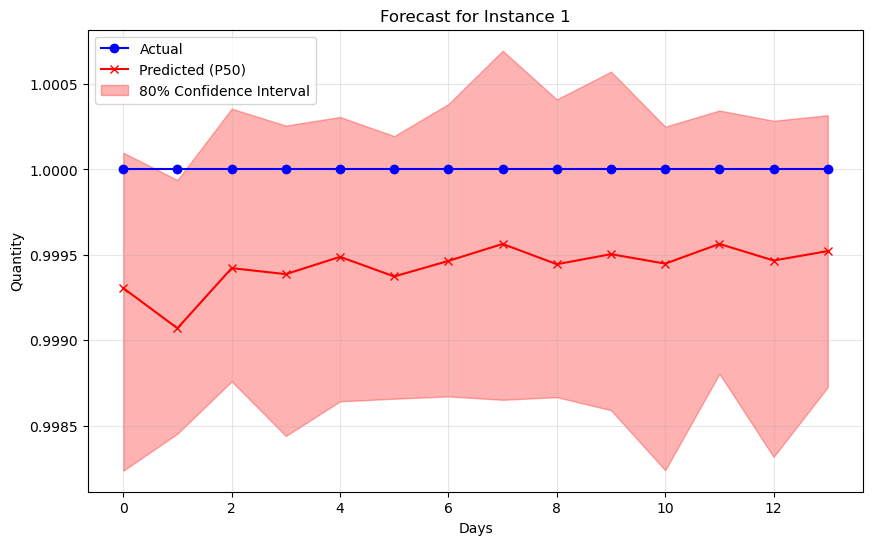


Evaluating test instance 2/10
Instance 2 Metrics:
  RMSE: 0.0006
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan


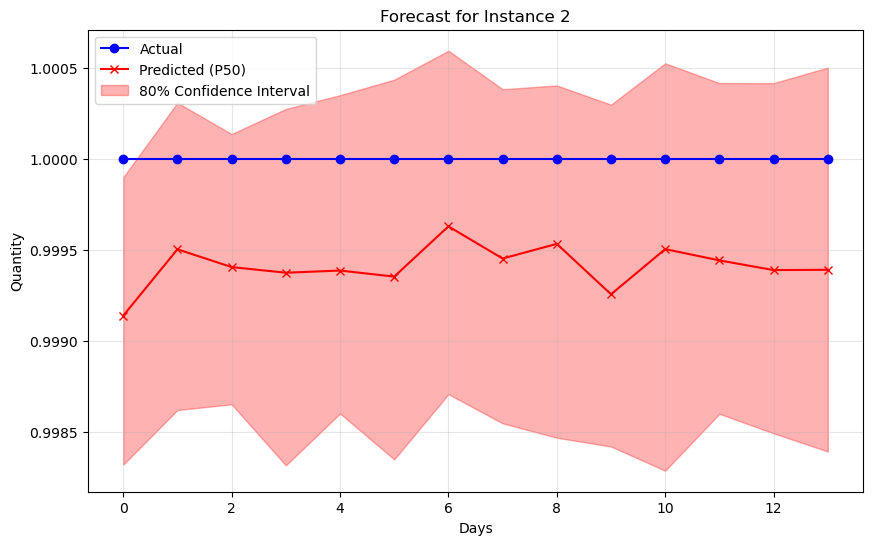


Evaluating test instance 3/10
Instance 3 Metrics:
  RMSE: 0.0006
  MAPE: 0.05%
  MAE: 0.0005
  MASE: nan


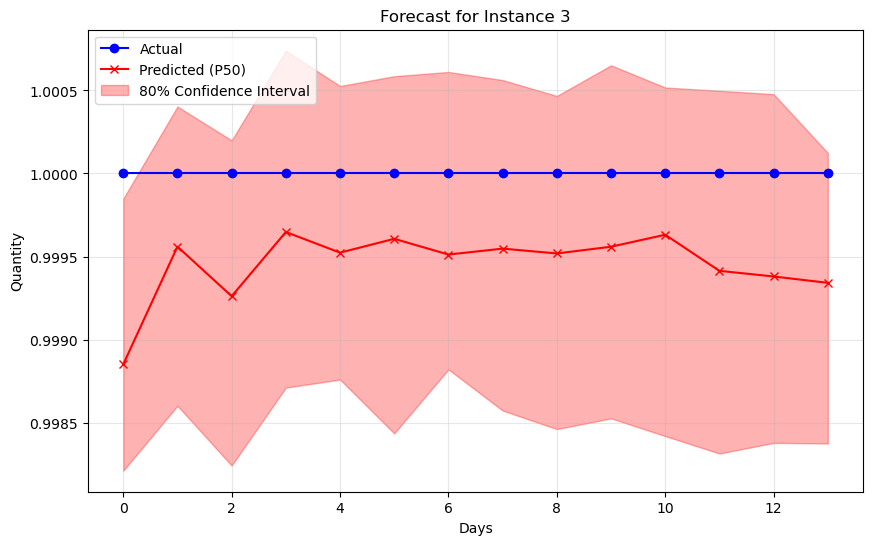


Evaluating test instance 4/10
Instance 4 Metrics:
  RMSE: 0.0006
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan


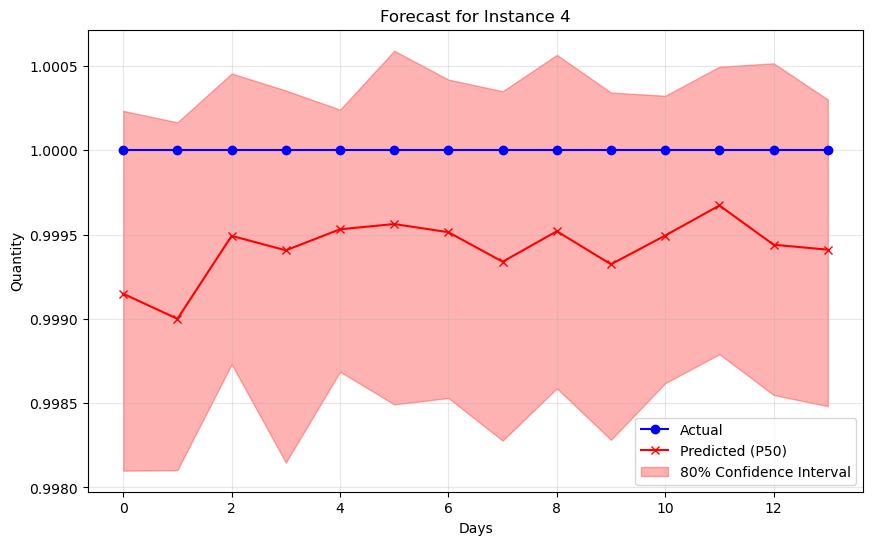


Evaluating test instance 5/10
Instance 5 Metrics:
  RMSE: 0.0006
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan


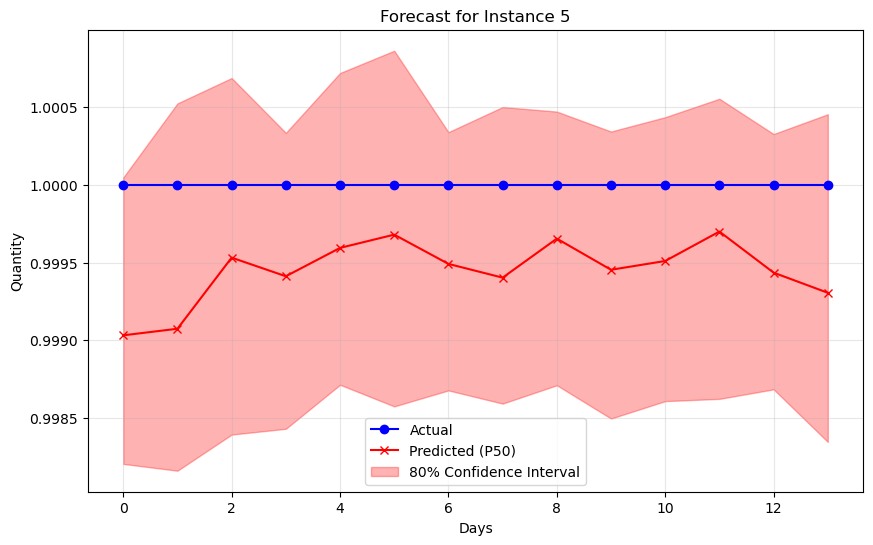


Evaluating test instance 6/10
Instance 6 Metrics:
  RMSE: 0.0007
  MAPE: 0.07%
  MAE: 0.0007
  MASE: nan


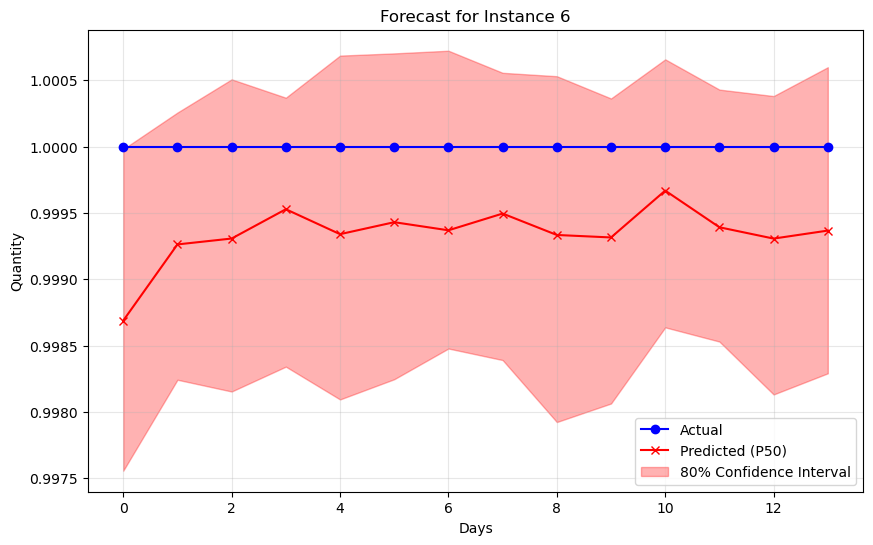


Evaluating test instance 7/10
Instance 7 Metrics:
  RMSE: 0.0007
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan


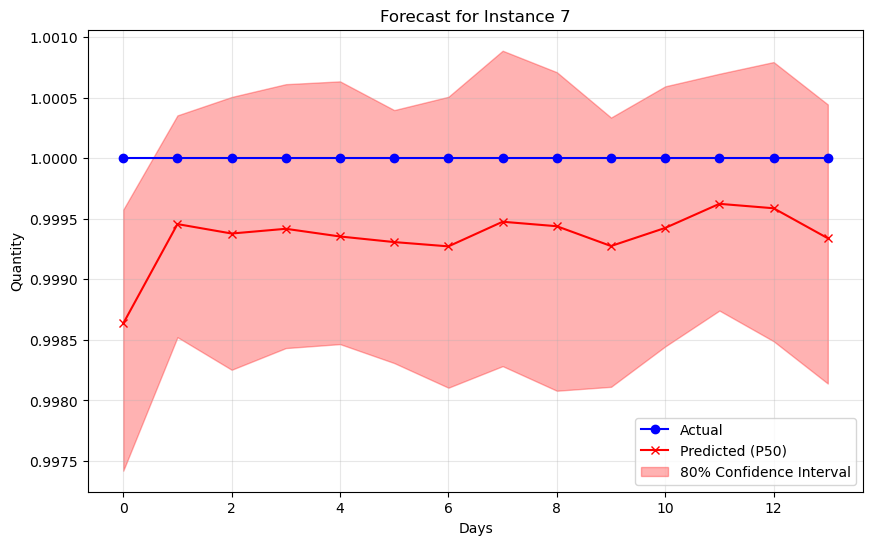


Evaluating test instance 8/10
Train instance doesn't have enough data for the prediction period

Evaluating test instance 9/10
Instance 9 Metrics:
  RMSE: 0.0007
  MAPE: 0.06%
  MAE: 0.0006
  MASE: nan


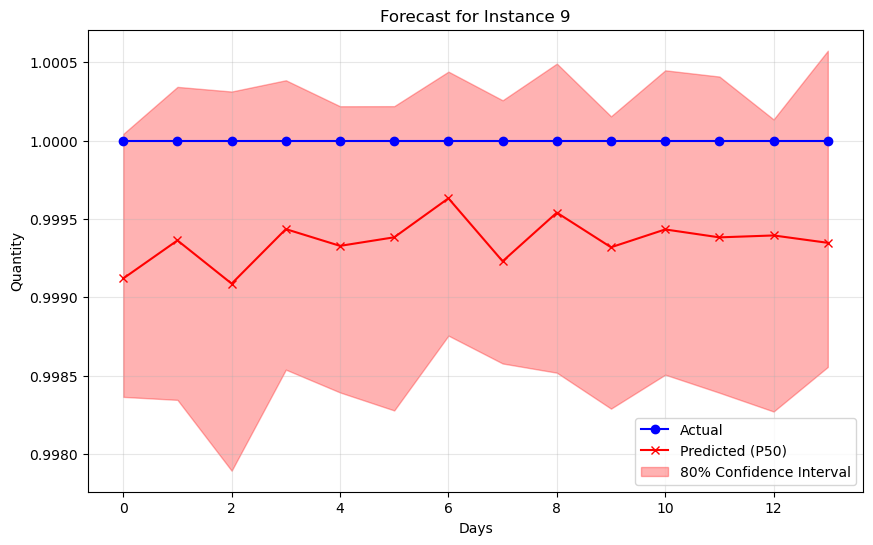


Evaluating test instance 10/10
Instance 10 Metrics:
  RMSE: 0.0008
  MAPE: 0.08%
  MAE: 0.0008
  MASE: nan


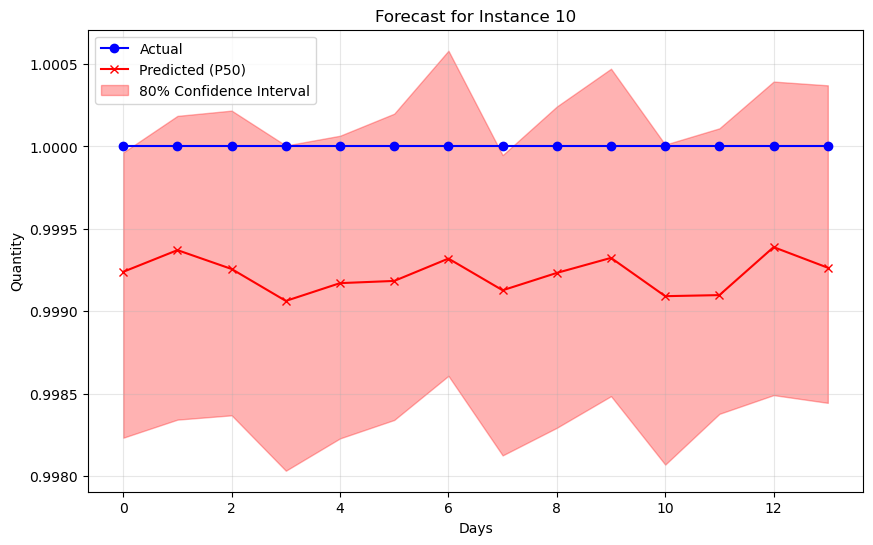


===== Overall Model Performance =====
Aggregate RMSE: 0.0006
Aggregate MAPE: 0.06%
Aggregate MAE: 0.0006
Aggregate MASE: nan


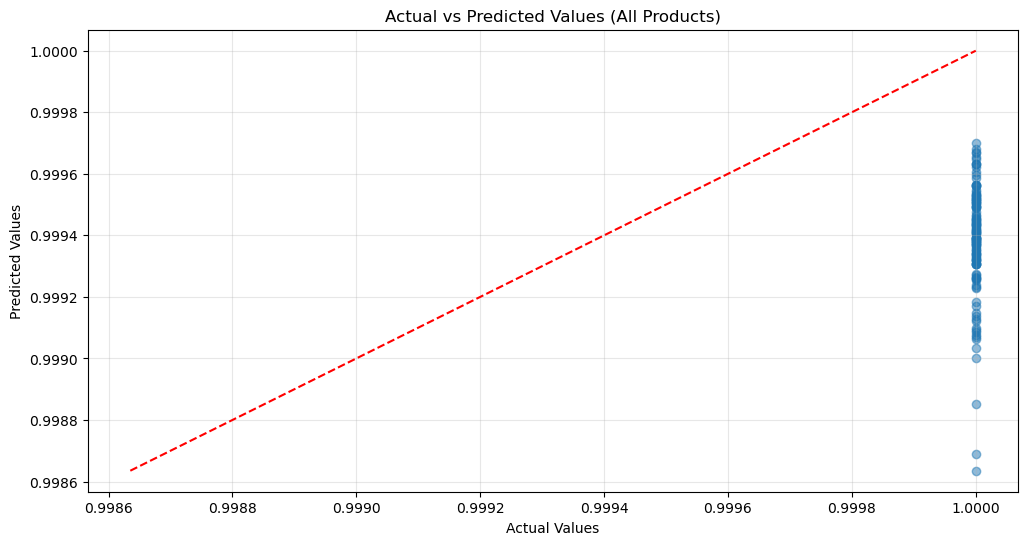

Results saved to model_evaluation_results.json

=== INTEGRATING WITH AMAZON BEDROCK FOR PRODUCT-SPECIFIC INSIGHTS ===
Bedrock insights saved to bedrock_product_insights.json

=== MODEL ANALYSIS ===

Performance Summary:
The model appears to be performing well overall, with low RMSE, MAPE, and MAE values across all products. However, there is no category information provided, so category-level insights cannot be generated.

Category Insights:

  Category: Unknown
  Performance: Without category information, it is difficult to assess performance at the category level. However, the aggregate metrics suggest good overall model performance.
  Recommendations: Collect and provide category information for each product to enable more detailed category-level analysis and recommendations.

=== PRODUCT RECOMMENDATIONS ===

Product: Product 9
  Product ID: ID-9
  Recommended Quantity: 10
  Order Timing: immediate
  Confidence: 75%
  Reasoning: This product has the highest RMSE and MAPE values, ind

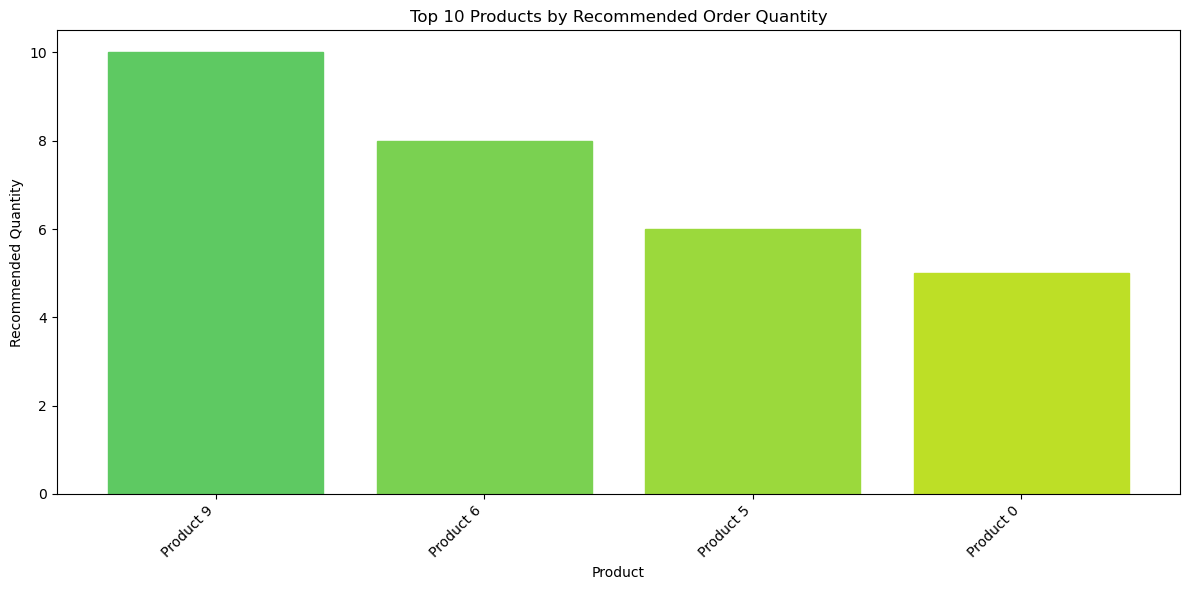

In [81]:
def evaluate_model_accuracy_with_product_info(test_file='test.json', train_file='train.json', forecast_df=None, num_instances=10):
    """Evaluate model accuracy using test data with product information"""
    print("Loading test data...")
    with open(test_file, 'r') as f:
        test_instances = [json.loads(line) for line in f]
    
    print("Loading train data...")
    with open(train_file, 'r') as f:
        train_instances = [json.loads(line) for line in f]
    
    print(f"Loaded {len(test_instances)} test instances and {len(train_instances)} train instances")
    
    # If forecast_df is not provided, try to load it
    if forecast_df is None:
        try:
            # Try to load forecast_df from a saved file
            forecast_df = pd.read_csv('forecast_df.csv')
            print("Loaded forecast_df from file")
        except:
            print("Warning: forecast_df not provided and couldn't be loaded from file")
            print("Product information will not be available")
    
    # Store results
    results = []
    all_actuals = []
    all_predictions = []
    
    # Process test instances
    for i, test_instance in enumerate(test_instances[:num_instances]):
        print(f"\nEvaluating test instance {i+1}/{min(num_instances, len(test_instances))}")
        
        # Find matching train instance to get the full time series
        matching_train = None
        for train_instance in train_instances:
            if (train_instance['start'] == test_instance['start'] and 
                'cat' in train_instance and 'cat' in test_instance and
                train_instance['cat'] == test_instance['cat']):
                matching_train = train_instance
                break
        
        if not matching_train:
            print(f"No matching train instance found for test instance {i+1}")
            continue
        
        # Get product information if forecast_df is available
        product_info = {}
        if forecast_df is not None:
            # Try to extract item_id from the test instance
            # This assumes that item_id follows the pattern: customer_id_facility_id_product_id
            if 'cat' in test_instance:
                cat_values = test_instance['cat']
                if len(cat_values) >= 3:
                    customer_id = cat_values[0]
                    facility_id = cat_values[1]
                    category_id = cat_values[2]
                    
                    # Try to find matching product in forecast_df
                    matching_products = forecast_df[
                        (forecast_df['customer_id'] == customer_id) & 
                        (forecast_df['facility_id'] == facility_id) & 
                        (forecast_df['category_name'].map(lambda x: hash(x) % 100) == category_id)
                    ]
                    
                    if not matching_products.empty:
                        first_match = matching_products.iloc[0]
                        product_info = {
                            'product_id': first_match.get('product_id', 'Unknown'),
                            'product_name': first_match.get('product_name', 'Unknown'),
                            'category_name': first_match.get('category_name', 'Unknown'),
                            'customer_id': first_match.get('customer_id', 'Unknown'),
                            'facility_id': first_match.get('facility_id', 'Unknown')
                        }
                        print(f"Found product: {product_info['product_name']}")
        
        # Get predictions from the endpoint
        predictions = get_predictions_from_endpoint(test_instance)
        if not predictions:
            print(f"Failed to get predictions for test instance {i+1}")
            continue
        
        # Extract the actual values for the prediction period
        test_target_len = len(test_instance['target'])
        train_target_len = len(matching_train['target'])
        
        # Check if train instance has enough data for the prediction period
        if train_target_len < test_target_len + prediction_length:
            print(f"Train instance doesn't have enough data for the prediction period")
            continue
        
        # Extract actual values for the prediction period
        actual_values = np.array(matching_train['target'][test_target_len:test_target_len + prediction_length])
        
        # Extract predicted values (p50)
        predicted_values = np.array(predictions['quantiles']['0.5'])
        
        # Calculate metrics
        metrics = calculate_accuracy_metrics(actual_values, predicted_values)
        
        # Store results with product information
        result = {
            'instance_index': i,
            'metrics': metrics,
            'actual_values': actual_values.tolist(),
            'predicted_values': predicted_values.tolist(),
            'p10_values': np.array(predictions['quantiles']['0.1']).tolist(),
            'p90_values': np.array(predictions['quantiles']['0.9']).tolist()
        }
        
        # Add product information if available
        if product_info:
            result['product_info'] = product_info
        
        results.append(result)
        
        # Add to aggregate metrics
        all_actuals.extend(actual_values)
        all_predictions.extend(predicted_values)
        
        # Print metrics with product name if available
        product_name = product_info.get('product_name', f"Instance {i+1}")
        print(f"{product_name} Metrics:")
        print(f"  RMSE: {metrics['RMSE']:.4f}")
        print(f"  MAPE: {metrics['MAPE']:.2f}%")
        print(f"  MAE: {metrics['MAE']:.4f}")
        print(f"  MASE: {metrics['MASE']:.4f}")
        
        # Plot actual vs predicted
        plt.figure(figsize=(10, 6))
        plt.plot(range(prediction_length), actual_values, 'b-', label='Actual', marker='o')
        plt.plot(range(prediction_length), predicted_values, 'r-', label='Predicted (P50)', marker='x')
        plt.fill_between(
            range(prediction_length),
            predictions['quantiles']['0.1'],
            predictions['quantiles']['0.9'],
            color='r',
            alpha=0.3,
            label='80% Confidence Interval'
        )
        
        # Use product name in title if available
        if 'product_name' in product_info:
            plt.title(f'Forecast for {product_info["product_name"]}')
        else:
            plt.title(f'Forecast for Instance {i+1}')
            
        plt.xlabel('Days')
        plt.ylabel('Quantity')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # Calculate aggregate metrics
    if all_actuals and all_predictions:
        aggregate_metrics = calculate_accuracy_metrics(np.array(all_actuals), np.array(all_predictions))
        
        print("\n===== Overall Model Performance =====")
        print(f"Aggregate RMSE: {aggregate_metrics['RMSE']:.4f}")
        print(f"Aggregate MAPE: {aggregate_metrics['MAPE']:.2f}%")
        print(f"Aggregate MAE: {aggregate_metrics['MAE']:.4f}")
        print(f"Aggregate MASE: {aggregate_metrics['MASE']:.4f}")
        
        # Plot overall actual vs predicted
        plt.figure(figsize=(12, 6))
        plt.scatter(all_actuals, all_predictions, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(min(all_actuals), min(all_predictions))
        max_val = max(max(all_actuals), max(all_predictions))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.title('Actual vs Predicted Values (All Products)')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Create the complete evaluation results structure
        evaluation_results = {
            'individual_results': results,
            'aggregate_metrics': aggregate_metrics
        }
        
        # Save results
        with open('model_evaluation_results.json', 'w') as f:
            json.dump(evaluation_results, f, indent=2)
        
        print("Results saved to model_evaluation_results.json")
        
        return evaluation_results
    else:
        print("No valid results to calculate aggregate metrics")
        return None

def integrate_with_bedrock_for_products(evaluation_results, region_name='us-east-1'):
    """Generate business insights from model evaluation results using Amazon Bedrock with product information"""
    if not evaluation_results or 'individual_results' not in evaluation_results:
        print("No evaluation results available for Bedrock integration")
        return None
    
    # Set up Bedrock client
    bedrock_client = boto3.client('bedrock-runtime', region_name=region_name)
    bedrock_model_id = 'anthropic.claude-3-sonnet-20240229-v1:0'
    
    # Prepare data for Bedrock
    individual_results = evaluation_results['individual_results']
    aggregate_metrics = evaluation_results['aggregate_metrics']
    
    # Extract product information for each result
    product_results = []
    for result in individual_results:
        product_result = {
            'instance_index': result['instance_index'],
            'metrics': result['metrics'],
            'average_prediction': np.mean(result['predicted_values']),
            'prediction_trend': 'increasing' if result['predicted_values'][-1] > result['predicted_values'][0] else 'decreasing',
            'confidence_width': np.mean(np.array(result['p90_values']) - np.array(result['p10_values']))
        }
        
        # Add product information if available
        if 'product_info' in result:
            product_result['product_name'] = result['product_info'].get('product_name', 'Unknown')
            product_result['category'] = result['product_info'].get('category_name', 'Unknown')
            product_result['product_id'] = result['product_info'].get('product_id', 'Unknown')
        else:
            # Try to find product information from the forecast_df using item_id
            if 'item_id' in result and forecast_df is not None:
                item_id = result['item_id']
                matching_products = forecast_df[forecast_df['item_id'] == item_id]
                if not matching_products.empty:
                    first_match = matching_products.iloc[0]
                    product_result['product_name'] = first_match.get('product_name', f"Product {result['instance_index']}")
                    product_result['category'] = first_match.get('category_name', 'Unknown')
                    product_result['product_id'] = first_match.get('product_id', f"ID-{result['instance_index']}")
                else:
                    product_result['product_name'] = f"Product {result['instance_index']}"
                    product_result['category'] = 'Unknown'
                    product_result['product_id'] = f"ID-{result['instance_index']}"
            else:
                product_result['product_name'] = f"Product {result['instance_index']}"
                product_result['category'] = 'Unknown'
                product_result['product_id'] = f"ID-{result['instance_index']}"
        
        product_results.append(product_result)
    
    # Create prompt for Bedrock
    current_date = datetime.now().strftime("%Y-%m-%d")
    
    prompt = f"""
    Based on the following product-level forecasting results:
    
    Current date: {current_date}
    
    Aggregate Metrics:
    - RMSE: {aggregate_metrics['RMSE']:.4f}
    - MAPE: {aggregate_metrics['MAPE']:.2f}%
    - MAE: {aggregate_metrics['MAE']:.4f}
    - MASE: {aggregate_metrics['MASE']:.4f}
    
    Product-Level Results:
    {json.dumps(product_results, indent=2)}
    
    Please provide:
    1. Analysis of model performance by product category
    2. Specific procurement recommendations for each product
    3. Suggested order quantities and timing for each product
    4. Risk assessment for stock levels based on prediction confidence
    5. Prioritized list of products to focus on for inventory management
    
    Format your response as a JSON object:
    {{
      "model_analysis": {{
        "performance_summary": "description",
        "category_insights": [
          {{
            "category": "category name",
            "performance": "description",
            "recommendations": "category-specific recommendations"
          }}
        ]
      }},
      "product_recommendations": [
        {{
          "product_name": "specific product name",
          "product_id": "product identifier",
          "recommended_quantity": 5,
          "order_timing": "immediate/next week/etc.",
          "confidence": 85,
          "reasoning": "explanation"
        }}
      ],
      "inventory_priorities": [
        {{
          "product_name": "specific product name",
          "priority_level": "high/medium/low",
          "action": "specific action to take",
          "risk_level": "high/medium/low"
        }}
      ]
    }}
    """
    
    # Call Bedrock
    try:
        body = json.dumps({
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 2000,
            "temperature": 0.2,
            "messages": [
                {
                    "role": "user",
                    "content": prompt
                }
            ]
        })
        
        response = bedrock_client.invoke_model(
            modelId=bedrock_model_id,
            contentType='application/json',
            accept='application/json',
            body=body
        )
        
        response_body = json.loads(response['body'].read())
        response_text = response_body.get('content', [{}])[0].get('text', '')
        
        # Extract JSON from the response
        try:
            json_start = response_text.find('{')
            json_end = response_text.rfind('}') + 1
            if json_start >= 0 and json_end > json_start:
                json_str = response_text[json_start:json_end]
                insights = json.loads(json_str)
                
                # Save insights
                with open('bedrock_product_insights.json', 'w') as f:
                    json.dump(insights, f, indent=2)
                print("Bedrock insights saved to bedrock_product_insights.json")
                
                # Display insights
                print("\n=== MODEL ANALYSIS ===")
                if 'model_analysis' in insights:
                    analysis = insights['model_analysis']
                    print(f"\nPerformance Summary:")
                    print(analysis.get('performance_summary', 'No summary available'))
                    
                    if 'category_insights' in analysis:
                        print("\nCategory Insights:")
                        for category in analysis['category_insights']:
                            print(f"\n  Category: {category.get('category', 'Unknown')}")
                            print(f"  Performance: {category.get('performance', 'No data')}")
                            print(f"  Recommendations: {category.get('recommendations', 'No recommendations')}")
                
                print("\n=== PRODUCT RECOMMENDATIONS ===")
                if 'product_recommendations' in insights:
                    for rec in insights['product_recommendations']:
                        print(f"\nProduct: {rec.get('product_name', 'Unknown')}")
                        print(f"  Product ID: {rec.get('product_id', 'Unknown')}")
                        print(f"  Recommended Quantity: {rec.get('recommended_quantity', 'N/A')}")
                        print(f"  Order Timing: {rec.get('order_timing', 'N/A')}")
                        print(f"  Confidence: {rec.get('confidence', 'N/A')}%")
                        print(f"  Reasoning: {rec.get('reasoning', 'No reasoning provided')}")
                
                print("\n=== INVENTORY PRIORITIES ===")
                if 'inventory_priorities' in insights:
                    for priority in insights['inventory_priorities']:
                        print(f"\nProduct: {priority.get('product_name', 'Unknown')}")
                        print(f"  Priority Level: {priority.get('priority_level', 'N/A')}")
                        print(f"  Action: {priority.get('action', 'No action specified')}")
                        print(f"  Risk Level: {priority.get('risk_level', 'N/A')}")
                
                return insights
            else:
                raise ValueError("No JSON found in response")
        except Exception as json_error:
            print(f"Error parsing JSON from Bedrock response: {str(json_error)}")
            print(f"Raw response: {response_text}")
            return None
    except Exception as e:
        print(f"Error calling Bedrock: {str(e)}")
        return None

def evaluate_and_recommend_products(test_file='test.json', train_file='train.json', forecast_df_path=None, num_instances=10):
    """Complete pipeline: evaluate model, get product-specific insights, and make actionable recommendations"""
    # Load forecast_df if path is provided
    forecast_df = None
    if forecast_df_path:
        try:
            forecast_df = pd.read_csv(forecast_df_path)
            print(f"Loaded forecast_df from {forecast_df_path}")
        except Exception as e:
            print(f"Error loading forecast_df: {str(e)}")
    
    # Run evaluation with product information
    evaluation_results = evaluate_model_accuracy_with_product_info(
        test_file=test_file,
        train_file=train_file,
        forecast_df=forecast_df,
        num_instances=num_instances
    )
    
    # Check if we have valid evaluation results
    if evaluation_results is None:
        print("No evaluation results available for Bedrock integration")
        return None
    
    # Integrate with Bedrock for product-specific insights
    print("\n=== INTEGRATING WITH AMAZON BEDROCK FOR PRODUCT-SPECIFIC INSIGHTS ===")
    insights = integrate_with_bedrock_for_products(evaluation_results)
    
    # Create actionable procurement report
    if insights and 'product_recommendations' in insights:
        create_procurement_report(insights)
    
    return insights

def create_procurement_report(insights):
    """Create an actionable procurement report based on Bedrock insights"""
    if not insights or 'product_recommendations' not in insights:
        print("No product recommendations available for report")
        return
    
    # Create a DataFrame from product recommendations
    recommendations = insights['product_recommendations']
    df = pd.DataFrame(recommendations)
    
    # Sort by priority (if available) or confidence
    if 'priority_level' in df.columns:
        priority_map = {'high': 3, 'medium': 2, 'low': 1}
        df['priority_value'] = df['priority_level'].map(lambda x: priority_map.get(x.lower(), 0) if isinstance(x, str) else 0)
        df = df.sort_values('priority_value', ascending=False)
    elif 'confidence' in df.columns:
        df = df.sort_values('confidence', ascending=False)
    
    # Save to CSV
    df.to_csv('procurement_recommendations.csv', index=False)
    print("Actionable procurement recommendations saved to procurement_recommendations.csv")
    
    # Display the top recommendations
    print("\n=== TOP PROCUREMENT RECOMMENDATIONS ===")
    print(df[['product_name', 'recommended_quantity', 'order_timing', 'confidence']].head(10))
    
    # Create a visualization of recommended quantities
    plt.figure(figsize=(12, 6))
    
    # Get top 10 products by recommended quantity
    top_products = df.sort_values('recommended_quantity', ascending=False).head(10)
    
    # Create bar chart
    bars = plt.bar(top_products['product_name'], top_products['recommended_quantity'])
    
    # Color bars by confidence if available
    if 'confidence' in top_products.columns:
        colors = plt.cm.viridis(top_products['confidence'] / 100)
        for bar, color in zip(bars, colors):
            bar.set_color(color)
    
    # Add labels and title
    plt.title('Top 10 Products by Recommended Order Quantity')
    plt.xlabel('Product')
    plt.ylabel('Recommended Quantity')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Run the complete pipeline if executed directly
if __name__ == "__main__":
    # Specify the path to your forecast_df if available
    forecast_df_path = 'forecast_df.csv'  # Change this to your actual path
    
    evaluate_and_recommend_products(
        test_file='test.json',
        train_file='train.json',
        forecast_df_path=forecast_df_path,
        num_instances=10
    )


## 8. Continuous Retraining Pipeline

To keep the model up-to-date with new data, we'll set up a continuous retraining pipeline. This involves:

1. Collecting new data
2. Preprocessing and feature engineering
3. Retraining the model
4. Evaluating and deploying the updated model

In [105]:
def create_retraining_pipeline(bucket, prefix, role, hyperparameters, instance_type="ml.c5.2xlarge"):
    """Create a retraining pipeline for the DeepAR model"""
    from sagemaker.workflow.pipeline import Pipeline
    from sagemaker.workflow.steps import TrainingStep
    from sagemaker.workflow.pipeline_context import PipelineSession
    from sagemaker.inputs import TrainingInput
    
    # Create a pipeline session
    pipeline_session = PipelineSession()
    
    # Define input data channels
    train_input = TrainingInput(
        s3_data=f"s3://{bucket}/{prefix}/data/train",
        content_type="application/json"
    )
    
    test_input = TrainingInput(
        s3_data=f"s3://{bucket}/{prefix}/data/test",
        content_type="application/json"
    )
    
    # Create estimator
    estimator = sagemaker.estimator.Estimator(
        image_uri=retrieve("forecasting-deepar", region),
        role=role,
        instance_count=1,
        instance_type=instance_type,
        output_path=f"s3://{bucket}/{prefix}/output",
        sagemaker_session=pipeline_session,
        hyperparameters=hyperparameters
    )
    
    # Create training step
    training_step = TrainingStep(
        name="DeepARTraining",
        estimator=estimator,
        inputs={
            "train": train_input,
            "test": test_input
        }
    )

    print(f"s3://{bucket}/{prefix}/data/train")
    print(f"s3://{bucket}/{prefix}/data/test")
    print(f"s3://{bucket}/{prefix}/data/output")
    
    # Create pipeline
    pipeline = Pipeline(
        name=f"{prefix}-retraining-pipeline",
        steps=[training_step],
        sagemaker_session=pipeline_session
    )
    
    return pipeline

In [106]:
# Create and define the retraining pipeline
try:
    pipeline = create_retraining_pipeline(
        bucket=bucket,
        prefix=prefix,
        role=role,
        hyperparameters=hyperparameters
    )
    
    # Define the pipeline
    pipeline_definition = pipeline.definition()
    
    print("Pipeline created successfully!")
    
    # Optionally, create the pipeline in SageMaker
    pipeline.upsert(role_arn=role)
    print(f"Pipeline '{pipeline.name}' created/updated in SageMaker")
except Exception as e:
    print(f"Error creating pipeline: {str(e)}")
    print("Note: Pipeline creation requires SageMaker Pipelines to be enabled in your account.")
    print("You can still implement retraining using AWS Step Functions or scheduled Lambda functions.")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


s3://sagemaker-us-east-1-533267165065/procurement-partners-hybrent-deepar/data/train
s3://sagemaker-us-east-1-533267165065/procurement-partners-hybrent-deepar/data/test
s3://sagemaker-us-east-1-533267165065/procurement-partners-hybrent-deepar/data/output
Pipeline created successfully!


Pipeline 'procurement-partners-hybrent-deepar-retraining-pipeline' created/updated in SageMaker


In [102]:
from sagemaker import get_execution_role
role = get_execution_role()
print(role)

client = boto3.client('sagemaker')
response = client.list_pipelines()
for pipeline in response['PipelineSummaries']:
    print(pipeline['PipelineName'], pipeline['CreationTime'])


arn:aws:iam::533267165065:role/service-role/SageMaker-ExecutionRole-20250605T133175
procurement-partners-hybrent-deepar-retraining-pipeline 2025-07-11 13:43:36.252000+00:00


### Alternative Retraining Approach

If SageMaker Pipelines is not available, you can implement retraining using AWS Lambda functions triggered on a schedule or when new data arrives in S3. Here's a sketch of the process:

1. **Data Collection**: Store new order data in an S3 bucket
2. **Data Processing**: Use a Lambda function triggered by S3 events to process new data
3. **Model Retraining**: Use a Lambda function to start a SageMaker training job
4. **Model Deployment**: Use a Lambda function to deploy the new model

This can be orchestrated using AWS Step Functions or Amazon EventBridge rules.

## 9. Clean Up Resources

When you're done with the model, make sure to clean up resources to avoid unnecessary charges.

In [ ]:
# Delete the endpoint
try:
    predictor.delete_endpoint()
    print(f"Endpoint {predictor.endpoint_name} deleted successfully")
except Exception as e:
    print(f"Error deleting endpoint: {str(e)}")

## 10. Conclusion

In this notebook, we've implemented a complete end-to-end solution for product-level forecasting using Amazon SageMaker's DeepAR algorithm. The solution includes:

1. **Data Loading & Exploration**: We loaded and analyzed the procurement order data to understand patterns and relationships.

2. **Feature Engineering**: We transformed raw data into time series format with appropriate features, including temporal features and categorical encodings.

3. **Data Preparation for DeepAR**: We formatted the data according to DeepAR requirements, including handling categorical features and dynamic time features.

4. **Model Training**: We trained a DeepAR model with appropriate hyperparameters for the procurement forecasting task.

5. **Model Evaluation**: We evaluated the model's performance using various metrics like RMSE, MAPE, and weighted quantile loss.

6. **Inference & Deployment**: We deployed the model to a SageMaker endpoint and demonstrated how to generate forecasts for specific products.

7. **Continuous Retraining**: We outlined approaches for setting up automated retraining pipelines to keep the model up-to-date with new data.

This solution provides a robust framework for product-level demand forecasting that can be extended and customized for specific business needs.